In [60]:
from collections.abc import Iterable

import numpy
import math
import textwrap
import matplotlib.pyplot as plt

import Double
import Norms
import Derivs
import SysNonlinEqSolvers
import Interpolation

In [175]:
def SolveSystemFPI2(F, x0, eps, norm, residuals = None, maxIters = 30):
    xn = x0
    iterNum = 1
    while (True):
        xn1 = F(xn)
        r = norm(xn1 - xn)

        iterNum += 1
        xn = xn1

        if (residuals is not None):
            residuals.append(r)

        if (abs(r) < eps):
            #print(f"FPI sys solver. ItersCount = {iterNum}")
            return xn1

        if (iterNum > maxIters):
            #print(f"FPI sys solver. Exceed ItersCount = {iterNum}")
            return xn1

def SolveSystemNewton2(F, derF, x0, eps, norm, residuals = None, maxIters = 30):
    xn = x0
    iterNum = 1

    printDebug = False

    while (True):
        A = derF(xn)

        if (printDebug):
            print(f"\nNewton sys solver. derF = {A}\n")

        f = F(xn)

        if (printDebug):
            print(f"\nNewton sys solver. f = {f}\n")

        if (isinstance(A, Iterable)):
            try:
                invA = numpy.linalg.inv(A)
            except numpy.linalg.LinAlgError:
                return SolveSystemFPI2(F, xn, eps, norm, residuals, maxIters)
        else:
            invA = 1/A
        
        if (printDebug):
            print(f"Newton sys solver. inv A = {invA}")
            print(f"Newton sys solver. dx = {-numpy.dot(invA, f)}")
            print(f"Newton sys solver. new x = {xn - numpy.dot(invA, f)}\n")
            print(f"Newton sys solver. res = {xn - numpy.dot(invA, f) - xn}\n")

        xn1 = xn - numpy.dot(invA, f)
        res = xn1 - xn
        r = norm(res)
            
        iterNum += 1
        xn = xn1

        if (residuals is not None):
            residuals.append(r)

        if (abs(r) < eps):
            #print(f"Newthon sys solver. ItersCount = {iterNum}")
            return xn1

        if (iterNum > maxIters):
            print(f"Newthon sys solver. Exceed ItersCount = {iterNum}")
            return xn1
        

def CalcJacobiMatrix(F, x, deriv_funct, x_step, dtype = numpy.float64):
    if (not isinstance(x, Iterable)):
        return deriv_funct(F, x, x_step)

    derF = numpy.zeros((len(x), len(x)), dtype=dtype)
    for columnIndex in range(0, len(x)):
        partialX = numpy.copy(x)
        def helper(x):
            nonlocal partialX
            partialX[columnIndex] = x
            #print(f"Jacobi: f{partialX} == {F(partialX)}")
            return F(partialX)
        derColumn = deriv_funct(helper, x[columnIndex], x_step)
        for rowIndex in range(0, len(x)):
            derF[rowIndex][columnIndex] = derColumn[rowIndex]
    return derF

# Методы Рунге-Кутты

In [3]:
def RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau):
    """
    Решает ОДУ или систему ОДУ методом Рунге-Кутты с помощью таблицы Бутчера.

    Аргументы:
        t0, y0     - начальное приближение (скаляры для ОДУ, векторы для системы).
        tau        - шаг по времени.
        stepsCount - число шагов по времени.
        funct      - функция, задающая уравнение, или вектор-функция для системы.
        ButchersTable, ButchersY, ButchersTau - таблица Бутчера:
        B |
        u |
        t |
        c |
        h |
        e |       ButchersTable
        r |
        s |
        T |
        a |
        u |
        ------------------------------
          |         ButchersY
        Пример:
            Метод Эйлера 1 порядка:
                0 | 0
                -----
                  | 1

                ButchersTable = [[0]]
                ButchersTau   =  [0]
                ButchersY     =  [1]

            Метод Рунге-Кутты 3 порядка:
                0   |  0   0   0
                1/2 | 1/2  0   0
                1   |  0   1   0
                -----------------
                    | 1/6 2/3 1/6

                ButchersTable = [[ 0,   0,   0], 
                                 [1/2,  0,   0],
                                 [ 0    1,   0]]
                ButchersTau   =  [ 0,  1/2,  1]
                ButchersY     =  [1/6, 2/3, 1/6]

    Возвращает t, y - решение (либо массивы скаляров для ОДУ, либо массивы векторов для системы ОДУ).
    """

    assert(len(ButchersTable) == len(ButchersY))
    assert(len(ButchersTable[0]) == len(ButchersY))
    assert(len(ButchersTau) == len(ButchersY))

    tn = t0
    yn = y0
    t = [t0]
    y = [y0]

    printDebug = False

    stagesCount = len(ButchersY)
    for n in range(0, stepsCount):
        
        if (printDebug):
            print(f"\nRungeKutta. t = {tn}\n\n")

        k = []
        for st in range(0, stagesCount):
            ksum = 0
            for st1 in range(0, st):
                ksum += ButchersTable[st][st1] * k[st1]
            k = numpy.array(list(k) + [funct(tn + ButchersTau[st] * tau, yn + tau * ksum)])
            if (printDebug):
                print("k:\n", k)
                print("ksum:\n", ksum)
                print("funct:\n", funct(tn + ButchersTau[st] * tau, yn + tau * ksum))
        #     print("knew:\n", k)
        # print("yn:\n", yn)

        if (printDebug):
            print("k:\n", k)
        ysum = 0
        for st in range(0, len(ButchersY)):
            ysum += ButchersY[st] * k[st]
        # print("numpy.matmul(ButchersY, k):\n", numpy.matmul(ButchersY, k))
        # print("numpy.sum(numpy.matmul(ButchersY, k)):\n", numpy.sum(numpy.matmul(ButchersY, k)))
        # print("ysum:\n", ysum)
        yn1 = yn + tau * ysum
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)

def Euler1(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0]])
    ButchersTau   = numpy.array([0])
    ButchersY     = numpy.array([1])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

def Euler2(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0, 0],
                                 [1/2, 0]])
    ButchersTau   = numpy.array([0, 1/2])
    ButchersY     = numpy.array([0, 1])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

def Heun3(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0, 0, 0],
                                 [1/3, 0, 0],
                                 [0, 2/3, 0]])
    ButchersTau   = numpy.array([0, 1/3, 2/3])
    ButchersY     = numpy.array([1/4, 0, 3/4])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

def RungeKutta3(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0, 0, 0],
                                 [1/2, 0, 0],
                                 [0, 1, 0]])
    ButchersTau   = numpy.array([0, 1/2, 1])
    ButchersY     = numpy.array([1/6, 2/3, 1/6])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

def RungeKutta4(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0, 0, 0, 0],
                                 [1/2, 0, 0, 0],
                                 [0, 1/2, 0, 0],
                                 [0, 0, 1, 0]])
    ButchersTau   = numpy.array([0, 1/2, 1/2, 1])
    ButchersY     = numpy.array([1/6, 2/6, 2/6, 1/6])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

def Butchers6(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0, 0, 0, 0, 0, 0, 0],
                                 [1/2, 0, 0, 0, 0, 0, 0],
                                 [2/9, 4/9, 0, 0, 0, 0, 0],
                                 [7/36, 2/9, -1/12, 0, 0, 0, 0],
                                 [-35/144, -55/36, 35/48, 15/8, 0, 0, 0],
                                 [-1/360, -11/36, -1/8, 1/2, 1/10, 0, 0],
                                 [-41/260, 22/13, 43/156, -118/39, 32/195, 80/39, 0]])
    ButchersTau   = numpy.array([0, 1/2, 2/3, 1/3, 5/6, 1/6, 1])
    ButchersY     = numpy.array([13/200, 0, 11/40, 11/40, 4/25, 4/25, 13/200])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

def Butchers6(t0, y0, tau, stepsCount, funct):
    ButchersTable = numpy.array([[0, 0, 0, 0, 0, 0, 0],
                                 [1/2, 0, 0, 0, 0, 0, 0],
                                 [2/9, 4/9, 0, 0, 0, 0, 0],
                                 [7/36, 2/9, -1/12, 0, 0, 0, 0],
                                 [-35/144, -55/36, 35/48, 15/8, 0, 0, 0],
                                 [-1/360, -11/36, -1/8, 1/2, 1/10, 0, 0],
                                 [-41/260, 22/13, 43/156, -118/39, 32/195, 80/39, 0]])
    ButchersTau   = numpy.array([0, 1/2, 2/3, 1/3, 5/6, 1/6, 1])
    ButchersY     = numpy.array([13/200, 0, 11/40, 11/40, 4/25, 4/25, 13/200])
    return RungeKuttaExplicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau)

# Неявные методы Рунге-Кутты

In [4]:
def RungeKuttaImlicit(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau, eps=1e-6):
    """
    Решает ОДУ или систему ОДУ неявным методом Рунге-Кутты с помощью таблицы Бутчера.

    Аргументы:
        t0, y0     - начальное приближение (скаляры для ОДУ, векторы для системы).
        tau        - шаг по времени.
        stepsCount - число шагов по времени.
        funct      - функция, задающая уравнение, или вектор-функция для системы.
        ButchersTable, ButchersY, ButchersTau - таблица Бутчера:
        B |
        u |
        t |
        c |
        h |
        e |       ButchersTable
        r |
        s |
        T |
        a |
        u |
        ------------------------------
          |         ButchersY
        Пример:
            Метод Эйлера 1 порядка:
                0 | 0
                -----
                  | 1

                ButchersTable = [[0]]
                ButchersTau   =  [0]
                ButchersY     =  [1]

            Метод Рунге-Кутты 3 порядка:
                0   |  0   0   0
                1/2 | 1/2  0   0
                1   |  0   1   0
                -----------------
                    | 1/6 2/3 1/6

                ButchersTable = [[ 0,   0,   0], 
                                 [1/2,  0,   0],
                                 [ 0    1,   0]]
                ButchersTau   =  [ 0,  1/2,  1]
                ButchersY     =  [1/6, 2/3, 1/6]

    Возвращает t, y - решение (либо массивы скаляров для ОДУ, либо массивы векторов для системы ОДУ).
    """

    assert(len(ButchersTable) == len(ButchersY))
    assert(len(ButchersTable[0]) == len(ButchersY))
    assert(len(ButchersTau) == len(ButchersY))
    assert(not isinstance(y0, Iterable))

    tn = t0
    yn = y0
    t = [t0]
    y = [y0]

    printDebug = False

    stagesCount = len(ButchersY)
    for n in range(0, stepsCount):
        if (printDebug):
            print(f"\nRungeKutta. t = {tn}\n\n")
            
        def F_helper(k):
            nonlocal tn
            nonlocal yn
            delta_k = []
            for st in range(0, stagesCount):
                ksum = 0
                for st1 in range(0, stagesCount):
                    if (printDebug):
                        print(f"F_helper: k[st1] == {k[st1]}")
                    ksum += ButchersTable[st][st1] * k[st1]
                delta_k.append(k[st] - funct(tn + ButchersTau[st] * tau, yn + tau * ksum))
                if (printDebug):
                    print(f"F_helper: ksum == {ksum}")
                    print(f"F_helper: funct({tn + ButchersTau[st] * tau}, {yn + tau * ksum})")
                    print(f"F_helper: delta_k = {delta_k}\n")
            if (printDebug):
                print(f"F_helper: delta_k = {delta_k}\n")
            return numpy.array(delta_k)
        
        def derF_helper(k):
            return CalcJacobiMatrix(F_helper, k, Derivs.DerivCentralO2, tau/10)
        
        k = SolveSystemNewton2(F_helper, derF_helper, numpy.ones(stagesCount), eps, Norms.NormV1, maxIters=20)

        ysum = 0
        for st in range(0, len(ButchersY)):
            ysum += ButchersY[st] * k[st]
        
        yn1 = yn + tau * ysum
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        tn = tn1
        yn = yn1
    return numpy.array(t), numpy.array(y)

def RungeKuttaImlicitSystem(t0, y0, tau, stepsCount, funct, ButchersTable, ButchersY, ButchersTau, eps=1e-6):
    assert(len(ButchersTable) == len(ButchersY))
    assert(len(ButchersTable[0]) == len(ButchersY))
    assert(len(ButchersTau) == len(ButchersY))
    assert(isinstance(y0, Iterable)) # переменная должна быть массивом переменных.

    tn = t0
    yn = y0
    t = [t0]
    y = [y0]
    var_dim = len(y0)

    printDebug = False

    def GetVect(k):
        veck = []
        for st in range(0, stagesCount):
            ar = []
            for st1 in range(0, var_dim):
                ar.append(k[st * var_dim + st1])
            veck.append(ar)
        return numpy.array(veck)

    stagesCount = len(ButchersY)
    for n in range(0, stepsCount):
        if (printDebug):
            print(f"\nRungeKutta. t = {tn}\n\n")

        def F_helper(k):
            delta_k = []
            k = GetVect(k)
            for st in range(0, stagesCount):
                ksum = numpy.zeros(var_dim)
                for st1 in range(0, stagesCount):
                    if (printDebug):
                        print(f"F_helper: k[st1] == {k[st1]}")
                    ksum += ButchersTable[st][st1] * k[st1]

                elem = k[st] - funct(tn + ButchersTau[st] * tau, yn + tau * ksum)
                delta_k += list(elem)

                if (printDebug):
                    print(f"F_helper: ksum == {ksum}")
                    print(f"F_helper: funct({tn + ButchersTau[st] * tau}, {yn + tau * ksum}) = {funct(tn + ButchersTau[st] * tau, yn + tau * ksum)}")
                    print(f"F_helper: delta_k = {delta_k}\n")
            if (printDebug):
                print(f"F_helper: delta_k = {delta_k}\n")
            return numpy.array(delta_k)
        
        def derF_helper(k):
            return CalcJacobiMatrix(F_helper, k, Derivs.DerivCentralO2, tau/10)
        
        kvec = SolveSystemNewton2(F_helper, derF_helper, numpy.zeros(stagesCount * var_dim), eps, Norms.NormV1, maxIters=20)
        k = GetVect(kvec)

        ysum = 0
        for st in range(0, stagesCount):
            ysum += ButchersY[st] * k[st]
        yn1 = yn + tau * ysum
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        tn = tn1
        yn = yn1
    return numpy.array(t), numpy.array(y)

def GetIEulerCoefs():
    ButchersTable = numpy.array([[1]])
    ButchersTau   = numpy.array([1])
    ButchersY     = numpy.array([1])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIRungeKutta2Coefs():
    ButchersTable = numpy.array([[1/4, 3/4], 
                                 [-5/12, 3/4]])
    ButchersTau   = numpy.array([1, 1/3])
    ButchersY     = numpy.array([1/4, 3/4])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIRungeKutta3Coefs():
    ButchersTable = numpy.array([[1/4, 3/4], 
                                 [-5/12, 3/4]])
    ButchersTau   = numpy.array([1, 1/3])
    ButchersY     = numpy.array([1/4, 3/4])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIRungeKutta4Coefs():
    ButchersTable = numpy.array([[1/6, 2/6, 2/6, 1/6],
                                 [-2/6, 2/6, 2/6, 1/6],
                                 [1/6, -1/6, 2/6, 1/6],
                                 [1/6, 2/6, -4/6, 1/6]])
    ButchersTau   = numpy.array([1, 1/2, 1/2, 0])
    ButchersY     = numpy.array([1/6, 2/6, 2/6, 1/6])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIGauss2Coefs():
    ButchersTable = numpy.array([[1/2]])
    ButchersTau   = numpy.array([1/2])
    ButchersY     = numpy.array([1])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIHammerHollingsworth4Coefs():
    ButchersTable = numpy.array([[1/4, 1/4 - math.sqrt(3)/6],
                                 [1/4 + math.sqrt(3)/6, 1/4]])
    ButchersTau   = numpy.array([1/2 - math.sqrt(3)/6, 1/2 + math.sqrt(3)/6])
    ButchersY     = numpy.array([1/2, 1/2])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIGauss6Coefs():
    ButchersTable = numpy.array([[5/36, 2/9 - math.sqrt(15)/15, 5/36 - math.sqrt(15)/30],
                                [5/36 + math.sqrt(15)/24, 2/9, 5/36-math.sqrt(15)/24],
                                 [5/36 + math.sqrt(15)/30, 2/9 + math.sqrt(15)/15, 5/36]])
    ButchersTau   = numpy.array([1/2 - math.sqrt(15)/10, 1/2, 1/2 + math.sqrt(15)/10])
    ButchersY     = numpy.array([5/18, 4/9, 5/18])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIRado3Coefs():
    ButchersTable = numpy.array([[5/12, -1/12],
                                 [3/4, 1/4]])
    ButchersTau   = numpy.array([1/3, 1])
    ButchersY     = numpy.array([3/4, 1/4])
    return (ButchersTable, ButchersY, ButchersTau)

def ILobatto2Coefs():
    ButchersTable = numpy.array([[0, 0],
                                 [1/2, 12]])
    ButchersTau   = numpy.array([0, 1])
    ButchersY     = numpy.array([1/2, 1/2])
    return (ButchersTable, ButchersY, ButchersTau)

def ILobatto4Coefs():
    ButchersTable = numpy.array([[0, 0, 0],
                                 [5/24, 1/3, -1/24],
                                 [1/6, 2/3, 1/6]])
    ButchersTau   = numpy.array([0, 1/2, 1])
    ButchersY     = numpy.array([1/6, 2/3, 1/6])
    return (ButchersTable, ButchersY, ButchersTau)

def GetIGauss6Coefs():
    ButchersTable = numpy.array([[1/2]])
    ButchersTau   = numpy.array([1/2])
    ButchersY     = numpy.array([1])
    return (ButchersTable, ButchersY, ButchersTau)

def IEuler1(t0, y0, tau, stepsCount, funct, eps = 1e-6):
    if (isinstance(y0, Iterable)):
        return RungeKuttaImlicitSystem(t0, y0, tau, stepsCount, funct, *GetIEulerCoefs(), eps)
    else:
        return RungeKuttaImlicit(t0, y0, tau, stepsCount, funct, *GetIEulerCoefs(), eps)

def IRungeKutta2(t0, y0, tau, stepsCount, funct, eps = 1e-6):
    if (isinstance(y0, Iterable)):
        return RungeKuttaImlicitSystem(t0, y0, tau, stepsCount, funct, *GetIRungeKutta2Coefs(), eps)
    else:
        return RungeKuttaImlicit(t0, y0, tau, stepsCount, funct,*GetIRungeKutta2Coefs(), eps)

def IRungeKutta3(t0, y0, tau, stepsCount, funct, eps = 1e-6):
    if (isinstance(y0, Iterable)):
        return RungeKuttaImlicitSystem(t0, y0, tau, stepsCount, funct, *GetIRungeKutta3Coefs(), eps)
    else:
        return RungeKuttaImlicit(t0, y0, tau, stepsCount, funct, *GetIRungeKutta3Coefs(), eps)

def IRungeKutta4(t0, y0, tau, stepsCount, funct, eps = 1e-6):
    if (isinstance(y0, Iterable)):
        return RungeKuttaImlicitSystem(t0, y0, tau, stepsCount, funct, *GetIRungeKutta4Coefs(), eps)
    else:
        return RungeKuttaImlicit(t0, y0, tau, stepsCount, funct, *GetIRungeKutta4Coefs(), eps)

# Методы Адамса

In [5]:
def Adams(t0  : [float], 
          y0  : [float], 
          tau : float, 
          stepsCount : int,
          funct, 
          AdamsCoefficients : numpy.array(float)):
    """
    Решает ОДУ или систему ОДУ методом Адамса.

    Аргументы:
        t0, y0            - начальное приближение (массив точек для ОДУ).
        tau               - шаг по времени.
        stepsCount        - число шагов по времени.
        funct             - функция, задающая уравнение, или вектор-функция для системы.
        AdamsCoefficients - коэффициенты метода Адамса (k штук).
                            u_{n+1} = u_{n} + tau * sum_{j=0}^{k-1} AdamsCoefficients_j * funct(t_n - tau * j)
        Пример:
            Метод Эйлера 1 порядка:
                AdamsCoefficients = [1]

            Метод Адамса 3 порядка:
                AdamsCoefficients = [23/12, -16/12, 5/12]

    Возвращает t, y - решение (либо массивы скаляров для ОДУ, либо массивы векторов для системы ОДУ).
    """
    assert(len(t0) == len(y0))
    assert(len(t0) == len(AdamsCoefficients))

    t = [ti for ti in t0]
    y = [yi for yi in y0]
    f = [funct(t0[st], y0[st]) for st in range(len(t0) - 1, -1, -1)]

    tn = t0[len(t0) - 1]
    yn = y0[len(y0) - 1]

    for n in range(0, stepsCount):
        sum = 0
        for st in range(0, len(AdamsCoefficients)):
            sum += AdamsCoefficients[st] * f[st]
        yn1 = yn + tau * sum
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        f.pop()
        f.insert(0, funct(tn1, yn1))
        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)

def Adams2(t0, y0, tau, stepsCount, funct):
    AdamsCoefficients = numpy.array([3/2, -1/2])
    t, y = Euler2(t0, y0, tau, len(AdamsCoefficients) - 1, funct)
    return Adams(t, y, tau, stepsCount - len(AdamsCoefficients) + 1, funct, AdamsCoefficients)

def Adams3(t0, y0, tau, stepsCount, funct):
    AdamsCoefficients = numpy.array([23/12, -16/12, 5/12])
    t, y = RungeKutta3(t0, y0, tau, len(AdamsCoefficients) - 1, funct)
    return Adams(t, y, tau, stepsCount - len(AdamsCoefficients) + 1, funct, AdamsCoefficients)

def Adams4(t0, y0, tau, stepsCount, funct):
    AdamsCoefficients = numpy.array([55/24, -59/24, 37/24, -9/24])
    t, y = RungeKutta4(t0, y0, tau, len(AdamsCoefficients) - 1, funct)
    return Adams(t, y, tau, stepsCount - len(AdamsCoefficients) + 1, funct, AdamsCoefficients)

# Неявные методы Адамса

In [6]:
def IAdams(t0  : [float], 
           y0  : [float], 
           tau : float, 
           stepsCount : int,
           funct, 
           AdamsCoefficients : numpy.array(float),
           eps = 1e-6):
    """
    Решает ОДУ или систему ОДУ методом Адамса.

    Аргументы:
        t0, y0            - начальное приближение (массив точек для ОДУ).
        tau               - шаг по времени.
        stepsCount        - число шагов по времени.
        funct             - функция, задающая уравнение, или вектор-функция для системы.
        AdamsCoefficients - коэффициенты неявного метода Адамса (k штук).
        Пример:
            Неявный метод Адамса 3 порядка:
                AdamsCoefficients = [5/12, 8/12, -1/12]
                u_{n+1} = u_n + tau * (5/12 f_{n+1} + 8/12 f_n - 1/12 f_{n-1})

    Возвращает t, y - решение (либо массивы скаляров для ОДУ, либо массивы векторов для системы ОДУ).
    """
    assert(len(t0) == len(y0))
    assert(len(t0) == len(AdamsCoefficients) - 1)

    t = [ti for ti in t0]
    y = [yi for yi in y0]
    f = [funct(t0[st], y0[st]) for st in range(len(t0) - 1, -1, -1)]

    tn = t0[len(t0) - 1]
    yn = y0[len(y0) - 1]

    debug = False

    if (debug):
        print(f"f0 = {f}\n")

    for n in range(0, stepsCount):
        tn1 = tn + tau

        def F(yn1):
            sum = AdamsCoefficients[0] * funct(tn1, yn1)
            for st in range(1, len(AdamsCoefficients)):
                if (debug):
                    print(f"st = {st}, f = {f[st - 1]} * coef = {AdamsCoefficients[st]}\n")
                sum += AdamsCoefficients[st] * f[st - 1]
            delta = yn1 - (yn + tau * sum)
            if (debug):
                print(f"yn1 = {yn1}\n")
                print(f"delta = {delta}\n")
            return delta
        
        def derF(yn1):
            J = CalcJacobiMatrix(F, yn1, Derivs.DerivCentralO2, tau/10)
            if (debug):
                print(f"J = {J}\n")
            return J
        
        yn1 = SolveSystemNewton2(F, derF, yn, eps, Norms.NormV1)

        t.append(tn1)
        y.append(yn1)

        f.pop()
        f.insert(0, funct(tn1, yn1))
        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)

def GetIAdams2Coefs():
    return numpy.array([1/2, 1/2])

def GetIAdams3Coefs():
    return numpy.array([5/12, 8/12, -1/12])

def GetIAdams4Coefs():
    return numpy.array([9/24, 19/24, -5/24, 1/24])

def IAdams2(t0, y0, tau, stepsCount, funct):
    AdamsCoefficients = GetIAdams2Coefs()
    return IAdams([t0], [y0], tau, stepsCount - len(AdamsCoefficients) + 1, funct, AdamsCoefficients)

def IAdams3(t0, y0, tau, stepsCount, funct):
    AdamsCoefficients = GetIAdams3Coefs()
    t, y = IRungeKutta3(t0, y0, tau, len(AdamsCoefficients) - 2, funct)
    return IAdams(t, y, tau, stepsCount - len(AdamsCoefficients) + 2, funct, AdamsCoefficients)

def IAdams4(t0, y0, tau, stepsCount, funct):
    AdamsCoefficients = GetIAdams4Coefs()
    t, y = IRungeKutta4(t0, y0, tau, len(AdamsCoefficients) - 2, funct)
    return IAdams(t, y, tau, stepsCount - len(AdamsCoefficients) + 2, funct, AdamsCoefficients)

# Формулы дифференцирования назад

In [7]:
def BDF(t0  : [float],
        y0  : [float],
        tau : float,
        stepsCount : int,
        funct,
        BDFCoefficients : numpy.array(float)):
    """
    Backward differentiation formula.
    
    Решает ОДУ или систему ОДУ по явным формулам дифференцирования назад.

    Аргументы:
        t0, y0          - начальное приближение (массив точек для ОДУ).
        tau             - шаг по времени.
        stepsCount      - число шагов по времени.
        funct           - функция, задающая уравнение, или вектор-функция для системы.
        BDFCoefficients - коэффициенты формул дифференцирования назад (k штук).
                            sum_{j=0}^{k-1} BDFCoefficients_j * y_{n - tau * j} = tau * f_n
        Пример:
            ФДН 2 порядка:
                BDFCoefficients = [1/2, -1/2]

            ФДН 3 порядка (неустойчива):
                BDFCoefficients = [1/3, 1/2, -1, 1/6]

    Возвращает t, y - решение (либо массивы скаляров для ОДУ, либо массивы векторов для системы ОДУ).
    """
    assert(len(t0) == len(y0))
    assert(len(t0) == len(BDFCoefficients) - 1)

    _yn = [y0[st] for st in range(len(y0) - 1, -1, -1)]

    t = [ti for ti in t0]
    y = [yi for yi in y0]
    
    tn = t0[len(t0) - 1]
    yn = y0[len(y0) - 1]

    for n in range(0, stepsCount):
        sum = 0
        for j in range(1, len(BDFCoefficients)):
            sum += BDFCoefficients[j] * _yn[j - 1]
        yn1 = 1/BDFCoefficients[0] * (tau * funct(tn, yn) - sum)
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        _yn.pop()
        _yn.insert(0, yn1)
        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)
    
def BDF2(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = numpy.array([1/2, 0, -1/2])
    t, y = Euler2(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return BDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

def BDF3(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = numpy.array([1/3, 1/2, -1, 1/6])
    t, y = RungeKutta3(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return BDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

# More methods https://en.wikipedia.org/w/index.php?title=Backward_differentiation_formula&oldid=1166087118

# Неявные формулы дифференцирования назад

In [8]:
def IBDF(t0  : [float],
        y0  : [float],
        tau : float,
        stepsCount : int,
        funct,
        BDFCoefficients : numpy.array(float),
        eps = 1e-6):
    """
    Backward differentiation formula.
    
    Решает ОДУ или систему ОДУ по явным формулам дифференцирования назад.

    Аргументы:
        t0, y0          - начальное приближение (массив точек для ОДУ).
        tau             - шаг по времени.
        stepsCount      - число шагов по времени.
        funct           - функция, задающая уравнение, или вектор-функция для системы.
        BDFCoefficients - коэффициенты формул дифференцирования назад (k штук).
        Пример:
            Неявная ФДН 3 порядка:
                BDFCoefficients = [11/6, -3, 3/2, -1/3]

    Возвращает t, y - решение (либо массивы скаляров для ОДУ, либо массивы векторов для системы ОДУ).
    """
    assert(len(t0) == len(y0))
    assert(len(t0) == len(BDFCoefficients) - 1)

    _yn = [y0[st] for st in range(len(y0) - 1, -1, -1)]

    t = [ti for ti in t0]
    y = [yi for yi in y0]
    
    tn = t0[len(t0) - 1]
    yn = y0[len(y0) - 1]

    for n in range(0, stepsCount):
        tn1 = tn + tau

        def F(yn1):
            sum = 0
            for j in range(1, len(BDFCoefficients)):
                sum += BDFCoefficients[j] * _yn[j - 1]
            new_yn1 = 1/BDFCoefficients[0] * (tau * funct(tn1, yn1) - sum)
            return yn1 - new_yn1
        
        def derF(yn1):
            return CalcJacobiMatrix(F, yn1, Derivs.DerivCentralO2, tau/10)
        
        yn1 = SolveSystemNewton2(F, derF, yn, eps, Norms.NormV1)

        t.append(tn1)
        y.append(yn1)

        _yn.pop()
        _yn.insert(0, yn1)
        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)

def GetIBDF2Coefs():
    return numpy.array([3/2, -2, 1/2])

def GetIBDF3Coefs():
    return numpy.array([11/6, -3, 3/2, -1/3])

def GetIBDF4Coefs():
    return numpy.array([25/12, -4, 3, -4/3, 1/4])

def GetIBDF5Coefs():
    return numpy.array([137/60, -5, 5, -10/3, 5/4, -1/5])

def GetIBDF6Coefs():
    return numpy.array([147/60, -6, 15/2, -20/3, 15/4, -6/5, 1/6])

def IBDF2(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = GetIBDF2Coefs()
    t, y = IRungeKutta2(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return IBDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

def IBDF3(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = GetIBDF3Coefs()
    t, y = IRungeKutta3(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return IBDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

def IBDF4(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = GetIBDF4Coefs()
    t, y = IRungeKutta4(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return IBDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

def IBDF5(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = GetIBDF5Coefs()
    t, y = IRungeKutta4(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return IBDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

def IBDF6(t0, y0, tau, stepsCount, funct):
    BDFCoefficients = GetIBDF6Coefs()
    t, y = IRungeKutta4(t0, y0, tau, len(BDFCoefficients) - 2, funct)
    return IBDF(t, y, tau, stepsCount - len(BDFCoefficients) + 2, funct, BDFCoefficients)

# CROS метод

In [9]:
def CROS2_s1(t0  : [float],
             y0  : [float],
             tau : float,
             stepsCount : int,
             funct,
             eps = 1e-6):
    """
    y_{n+1} = y_n + tau * Re{k}
    (E - tau * (1+i)/2 * df(y_n)/dy) * k = f(y_n)
    """
    assert(not isinstance(y0, Iterable))

    t = [t0]
    y = [y0]

    tn = t0
    yn = y0

    for n in range(0, stepsCount):
        def funct_helper(yn):
            return funct(tn, yn)
        
        J = Derivs.DerivCentralO2(funct_helper, yn, tau/10, numpy.complex128)

        def F(k):
            return (1 - tau * (1+1j)/2 * J) * k - funct(tn, yn)
            
        def derF(k):
            return CalcJacobiMatrix(F, k, Derivs.DerivCentralO2, tau/10, numpy.complex128)

        k = SolveSystemNewton2(F, derF, complex(0), eps, Norms.NormV1)

        yn1 = yn + tau * k.real
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)

def SysCROS2_s1(t0  : [float],
                y0  : [float],
                tau : float,
                stepsCount : int,
                funct,
                eps = 1e-6):
    """
    y_{n+1} = y_n + tau * Re{k}
    (E - tau * (1+i)/2 * df(y_n)/dy) * k = f(y_n)
    """
    assert(isinstance(y0, Iterable))

    t = [t0]
    y = [y0]

    tn = t0
    yn = y0

    dim = len(y0)

    for n in range(0, stepsCount):
        def funct_helper(yn):
            return funct(tn, yn)

        J = CalcJacobiMatrix(funct_helper, yn, Derivs.DerivCentralO2, tau/10, numpy.complex128)

        def F(k):
            E = numpy.eye(dim)
            return (E - tau * (1+1j)/2 * J) @ k - funct(tn, yn)
        
        def derF(k):
            return CalcJacobiMatrix(F, k, Derivs.DerivCentralO2, tau/10, numpy.complex128)

        k = SolveSystemNewton2(F, derF, numpy.zeros(dim, dtype=complex), eps, Norms.NormV1)

        yn1 = yn + tau * k.real
        tn1 = tn + tau

        t.append(tn1)
        y.append(yn1)

        tn = tn1
        yn = yn1

    return numpy.array(t), numpy.array(y)

# Представление Нордсика

In [248]:
def BinomCoef(n, k):
    C_n_k = 1
    for st in range(1, k + 1):
        C_n_k *= (n - st + 1) / (st)
    return C_n_k

def GetE1(k1):
    e1 = numpy.zeros((1, k1))
    e1[0][1] = 1
    return e1

def GetP(k1):
    P = numpy.zeros((k1, k1))
    for j in range(0, k1):
        for i in range(0, j + 1):
            P[i][j] = BinomCoef(j, i)
    return P

def SolveNordsieckEquation(t0  : [float],
                           y0  : [float],
                           tau : float,
                           stepsCount : int,
                           funct,
                           l,
                           eps = 1e-6):
    zn = numpy.zeros(len(l))
    zn[0] = y0
    zn[1] = tau * funct(t0, y0)

    def derY_T(t, y, k, tau):
        if (k == 1):
            return funct(t, y)
        
        derF_t = (derY_T(t + tau, y, k - 1, tau) - derY_T(t - tau, y, k - 1, tau)) / (2*tau)
        derF_y = (derY_T(t, y + tau, k - 1, tau) - derY_T(t, y - tau, k - 1, tau)) / (2*tau)
        derY_t = funct(t, y)
        return derF_t + derF_y * derY_t
    
    mn = tau
    for st in range(2, len(l)):
        mn *= tau / st
        zn[st] = mn * derY_T(t0, y0, st, tau/10)

    tn = t0
    yn = y0

    t = [t0]
    y = [y0]

    P = GetP(len(l))
    e1 = GetE1(len(l))

    for n in range(0, stepsCount):
        tn1 = tn + tau

        zn_corr = P @ zn - l[:, numpy.newaxis] @ e1 @ P @ zn

        def F(yn1):
            zn1 = l * tau * funct(tn1, yn1) + zn_corr
            return zn1[0] - yn1
        
        def derF(yn1):
            return CalcJacobiMatrix(F, yn1, Derivs.DerivCentralO2, tau/10)
        
        yn1 = SolveSystemNewton2(F, derF, yn, eps, Norms.NormV1)

        t.append(tn1)
        y.append(yn1)

        zn = l * tau * funct(tn1, yn1) + zn_corr
        tn = tn1
        yn = yn1
    
    return numpy.array(t), numpy.array(y)

def TensorDot(A, B):
    res = numpy.zeros((len(A) * len(B), len(A[0]) * len(B[0])))
    for aRowIndex in range(0, len(A)):
        for aColumnIndex in range(0, len(A[aRowIndex])):
            subMatr = A[aRowIndex][aColumnIndex] * B
            for st1 in range(0, len(subMatr)):
                for st2 in range(0, len(subMatr[st1])):
                    res[aRowIndex * len(B) + st1][aColumnIndex * len(B) + st2] = subMatr[st1][st2]
    return res

def SolveNordsieckSystem(t0  : [float],
                         y0  : [float],
                         tau : float,
                         stepsCount : int,
                         funct,
                         l,
                         eps = 1e-7):
    zn = numpy.zeros((len(l), len(y0)))
    zn[0] = y0
    zn[1] = tau * funct(t0, y0)

    def derY_T(t, y, k, tau):
        if (k == 1):
            return funct(t, y)
        
        derF_t = (derY_T(t + tau, y, k - 1, tau) - derY_T(t - tau, y, k - 1, tau)) / (2*tau)
        derF_y = 0
        derY_t = funct(t, y)

        for st in range(0, len(y)):
            yp = 1.0*y
            ym = 1.0*y
            yp[st] = yp[st] + tau
            ym[st] = ym[st] - tau
            derF_y += (derY_T(t, yp, k - 1, tau) - derY_T(t, ym, k - 1, tau)) / (2*tau) * derY_t[st]

        return derF_t + derF_y
    
    mn = tau
    for st in range(2, len(l)):
        mn *= tau / st
        zn[st] = mn * derY_T(t0, y0, st, tau)

    tn = t0
    yn = y0

    t = [t0]
    y = [y0]
    
    P = GetP(len(l))
    E = numpy.eye(len(y0))
    e1 = GetE1(len(l))

    size = len(l) * len(y0)
    zn = zn.reshape((size, 1))

    for n in range(0, stepsCount):
        tn1 = tn + tau

        zn_corr1 = TensorDot(P, E) @ zn
        zn_corr2 = -TensorDot(l[:, numpy.newaxis], E) @ TensorDot(e1 @ P, E) @ zn

        def F(yn1):
            fn1 = funct(tn1, yn1).reshape((len(y0), 1))
            zn1 = tau * TensorDot(l[:, numpy.newaxis], E) @ fn1 + zn_corr1 + zn_corr2
            delta = numpy.zeros(len(yn1))
            for st in range(0, len(delta)):
                delta[st] = zn1[st][0] - yn1[st]
            return delta
        
        def derF(yn1):
            return CalcJacobiMatrix(F, yn1, Derivs.DerivCentralO2, tau/10)
        
        yn1 = SolveSystemNewton2(F, derF, yn, eps, Norms.NormV1, maxIters = 100)

        t.append(tn1)
        y.append(yn1)

        fn1 = funct(tn1, yn1).reshape((len(y0), 1))
        zn = tau * TensorDot(l[:, numpy.newaxis], E) @ fn1 + zn_corr1 + zn_corr2
        tn = tn1
        yn = yn1
    
    return numpy.array(t), numpy.array(y)

In [167]:

def GetNordsieckAdams1L():
    return numpy.array([1/2, 1])

def GetNordsieckAdams2L():
    return numpy.array([5/12, 1, 1/2])

def GetNordsieckAdams3L():
    return numpy.array([3/8, 1, 3/4, 1/6])

def GetNordsieckAdams4L():
    return numpy.array([251/720, 1, 11/12, 1/3, 1/24])

def GetNordsieckAdams5L():
    return numpy.array([95/288, 1, 25/24, 35/72, 5/48, 1/120])

def GetNordsieckAdams6L():
    return numpy.array([19087/60480, 1, 137/120, 5/8, 17/96, 1/40, 1/720])

def NordsieckAdams1(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams1L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckAdams2(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams2L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckAdams3(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams3L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckAdams4(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams4L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckAdams5(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams5L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckAdams6(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams6L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemAdams1(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams1L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemAdams2(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams2L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemAdams3(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams3L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemAdams4(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams4L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemAdams5(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams5L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemAdams6(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckAdams6L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def GetNordsieckBDF1L():
    return numpy.array([1, 1])

def GetNordsieckBDF2L():
    return numpy.array([2/3, 1, 1/3])

def GetNordsieckBDF3L():
    return numpy.array([6/11, 1, 6/11, 1/11])

def GetNordsieckBDF4L():
    return numpy.array([12/25, 1, 7/10, 1/5, 1/50])

def GetNordsieckBDF5L():
    return numpy.array([60/137, 1, 225/274, 85/274, 15/274, 1/274])

def GetNordsieckBDF6L():
    return numpy.array([20/49, 1, 58/63, 5/12, 25/252, 1/84, 1/1764])

def NordsieckBDF1(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF1L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckBDF2(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF2L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckBDF3(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF3L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckBDF4(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF4L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckBDF5(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF5L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckBDF6(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF6L()
    return SolveNordsieckEquation(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemBDF1(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF1L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemBDF2(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF2L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemBDF3(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF3L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemBDF4(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF4L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemBDF5(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF5L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

def NordsieckSystemBDF6(t0  : [float],
                    y0  : [float],
                    tau : float,
                    stepsCount : int,
                    funct):
    l = GetNordsieckBDF6L()
    return SolveNordsieckSystem(t0, y0, tau, stepsCount, funct, l)

# Тестирование на простом ОДУ

Простое обыкновенное дифференциальное уравнение:
$$
y' + \alpha y = A \sin x + B \cos x +Cx +Dx^2 + E
$$
$$
y'(0) = y_0
$$
Простейшее аналитическое решение:
$$
y(x) = Const e^{-\alpha x} + \frac{\alpha A + B}{1 + \alpha^2} \sin x + \frac{\alpha B - A}{1 + \alpha^2} \cos x + (\frac{E}{\alpha} - \frac{C - \frac{2D}{\alpha}}{\alpha^2}) + \frac{C - \frac{2D}{\alpha}}{\alpha} x + \frac{D}{\alpha}x^2
$$
$$
Const = \left(y_0 - \left( \frac{\alpha A + B}{1 + \alpha^2} \sin x_0 + \frac{\alpha B - A}{1 + \alpha^2} \cos x_0 + (\frac{E}{\alpha} - \frac{C - \frac{2D}{\alpha}}{\alpha^2}) + \frac{C - \frac{2D}{\alpha}}{\alpha} x_0 + \frac{D}{\alpha}x_0^2 \right) \right) e^{\alpha x_0}
$$

In [34]:
def BuildPlot(x, y, plt_label, *args, **kwargs):
    if (not isinstance(y[0], Iterable)):
        plt.plot(x, y, *args, label = plt_label, **kwargs)
    else:
        for st in range(0, len(y[0])):
            plt.plot(x, y[:, st], *args, label = f"{plt_label}[{st}]", **kwargs)

def Test(t0, t1, y0, stepsCount, methods, equRefSol, equFunct):
    tau = (t1 - t0) / stepsCount

    tref = numpy.arange(t0, t1 + tau, tau)
    yref = equRefSol(tref, t0, y0)

    t = []
    y = []

    for st in range(0, len(methods)):
        ti, yi = methods[st](t0, y0, tau, stepsCount, equFunct)
        t.append(numpy.copy(ti))
        y.append(numpy.copy(yi))

    plt.title("Решение")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    BuildPlot(tref, yref, "Analytic")
    for st in range(0, len(methods)):
        BuildPlot(t[st], y[st], methods[st].__name__)
    plt.grid()
    plt.legend()
    plt.show()

    plt.title("Ошибка вычислений")
    plt.xlabel("t")
    plt.ylabel("$\log{|y_{выч.} - y_{аналит.}|}$")
    for st in range(0, len(methods)):
        res = numpy.log10(numpy.abs(equRefSol(t[st], t0, y0) - y[st]) + 1e-20)
        BuildPlot(t[st], res, methods[st].__name__)
    plt.grid()
    plt.legend()
    plt.show()

def TestGrid(t0, t1, y0, methods,
             equRefSol, equFunct, 
             stepsStart = 128, stepsStop = 2048*4, 
             BuildSolutionPlots = False, stepsCountSolPlot = 1e3):

    res = []
    for st in range(0, len(methods)):
        res.append([])
    steps = []
    
    if (BuildSolutionPlots):
        tau = (t1 - t0) / stepsCountSolPlot
        tref = numpy.arange(t0, t1 + tau, tau)
        yref = equRefSol(tref, t0, y0)
        plt.title("Сходимость по сетке")
        BuildPlot(tref, yref, "Analytic")

    while (stepsStart <= stepsStop):
        for st in range(0, len(methods)):
            tau = (t1 - t0) / stepsStart
            _t, _y = methods[st](t0, y0, tau, stepsStart, equFunct)

            if (BuildSolutionPlots):
                BuildPlot(_t, _y, f"{methods[st].__name__}, {stepsStart}")

            _res = equRefSol(_t, t0, y0) - _y

            res[st].append(math.log10(Norms.NormV1(_res)))
        steps.append(stepsStart)
        stepsStart *= 2
    
    if (BuildSolutionPlots):
        plt.grid()
        plt.legend()
        plt.show()

    plt.title("Сходимость по сетке")
    plt.xlabel("Размер сетки")
    plt.ylabel("$\log (\max |{y_{выч.} - y_{аналит.}}|)$")
    for st in range(0, len(methods)):
        BuildPlot(steps, res[st], methods[st].__name__, marker = ".")
    plt.grid()
    plt.legend()
    plt.show()

    if (False):
        plt.title("Сходимость по сетке\nв двойном логарифмическом масштабе")
        plt.xlabel("log(размер сетки)")
        plt.ylabel("$\log (\max |{y_{выч.} - y_{аналит.}}|) + offset$")
        for st in range(0, len(methods)):
            plt.plot(numpy.log2(steps), numpy.array(res[st]) - res[st][0], marker = '.', label = methods[st].__name__)
        plt.grid()
        plt.legend()
        plt.show()

In [35]:
alpha = 1
A1 = 2
B1 = -1
C1 = -0.01
D1 = 0.05
E1 = 0.5

def SimpleEquationFunction(x, y):
    global alpha, A1, B1, C1, E1, D1
    return - alpha * y + A1 * numpy.sin(x) + B1 * numpy.cos(x) + E1 + C1 * x + D1*x**2

def SimpleEquationAnalyticFreePart(x):
    global alpha, A1, B1, C1, E1, D1
    return (alpha * A1 + B1) / (1 + alpha**2) * numpy.sin(x) + (alpha * B1 - A1) / (1 + alpha**2) * numpy.cos(x) + (E1/alpha - (C1-2*D1/alpha)/alpha**2) + (C1-2*D1/alpha)/alpha * x + D1/alpha*x**2

def SimpleEquationConst(x0, y0):
    return (y0 - SimpleEquationAnalyticFreePart(x0)) * math.exp(alpha * x0)

def SimpleEquationAnalyticalSolution(x, x0, y0):
    return SimpleEquationConst(x0, y0) * numpy.exp(-alpha * x) + SimpleEquationAnalyticFreePart(x)

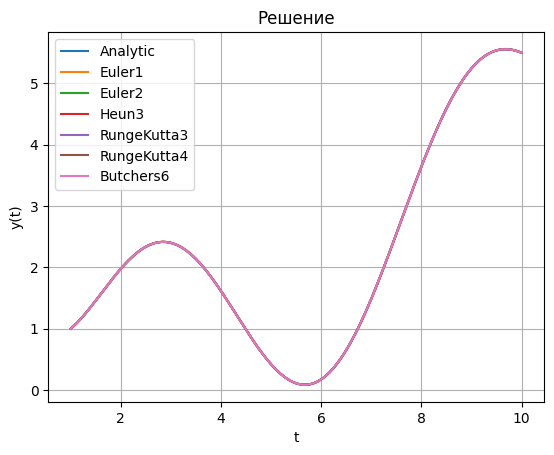

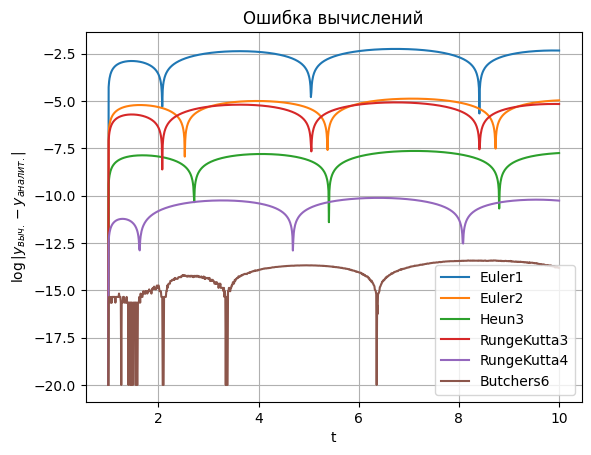

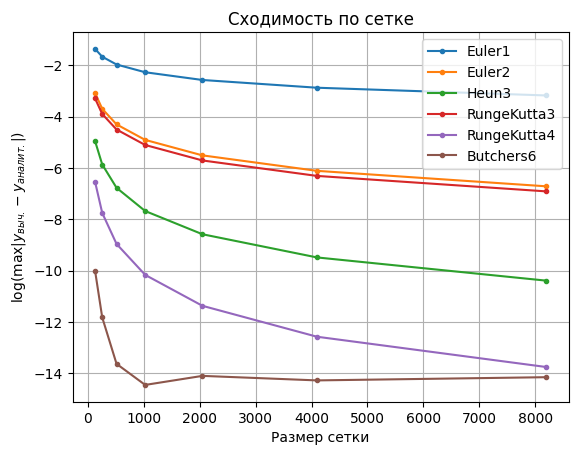

In [36]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [Euler1, Euler2, Heun3, RungeKutta3, RungeKutta4, Butchers6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

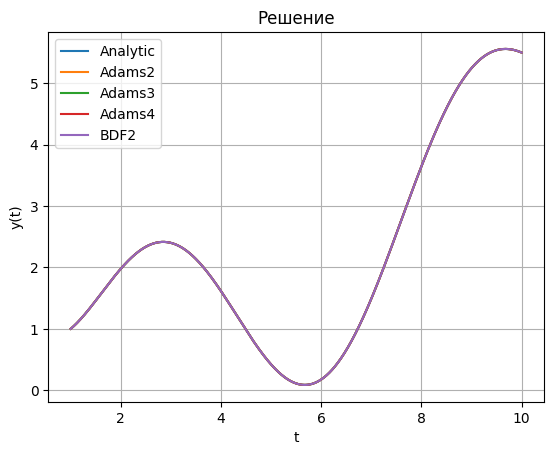

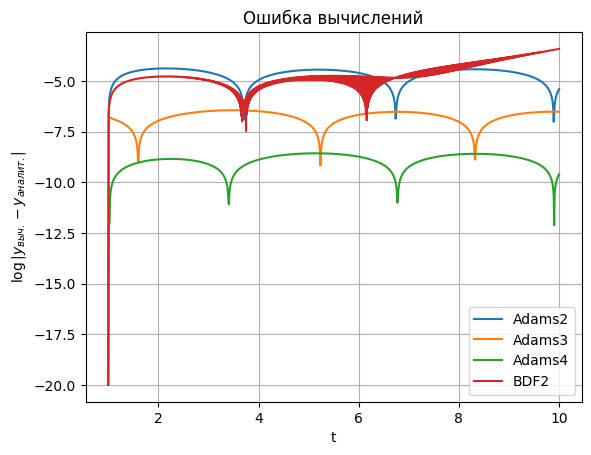

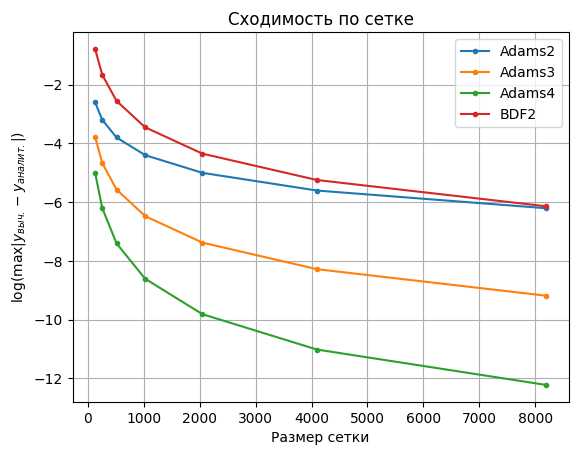

In [36]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [Adams2, Adams3, Adams4, BDF2]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

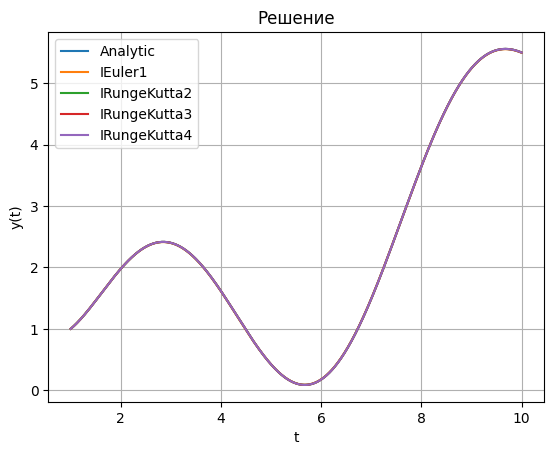

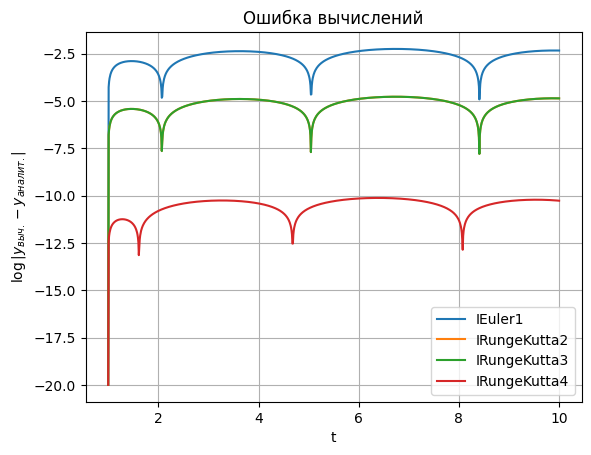

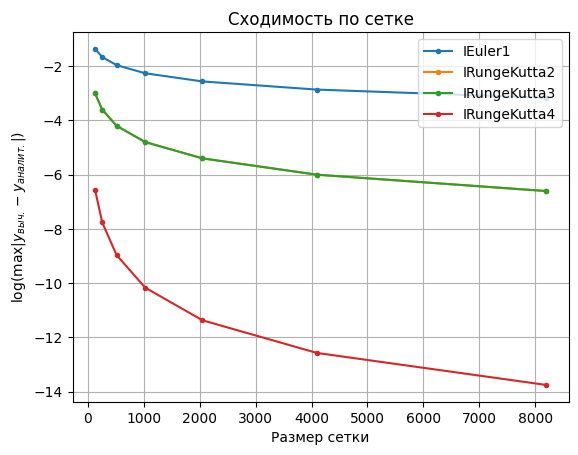

In [42]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [IEuler1, IRungeKutta2, IRungeKutta3, IRungeKutta4]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

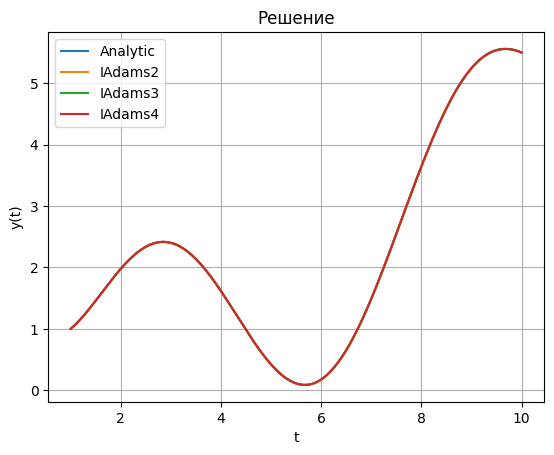

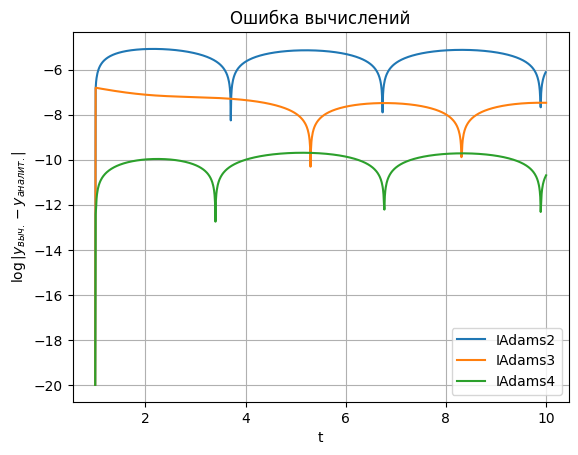

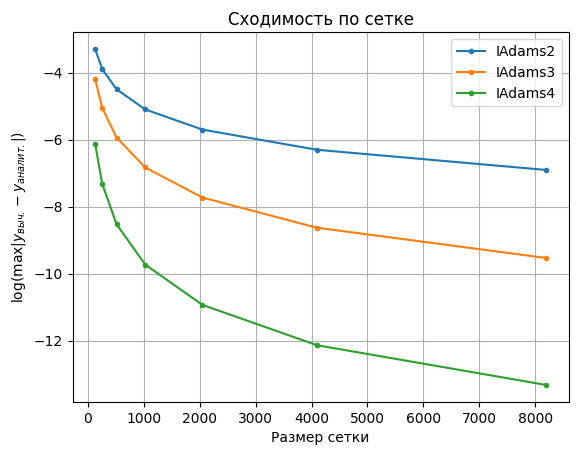

In [135]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [IAdams2, IAdams3, IAdams4]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

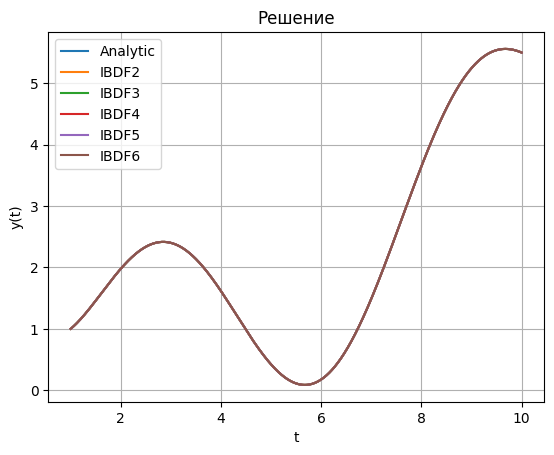

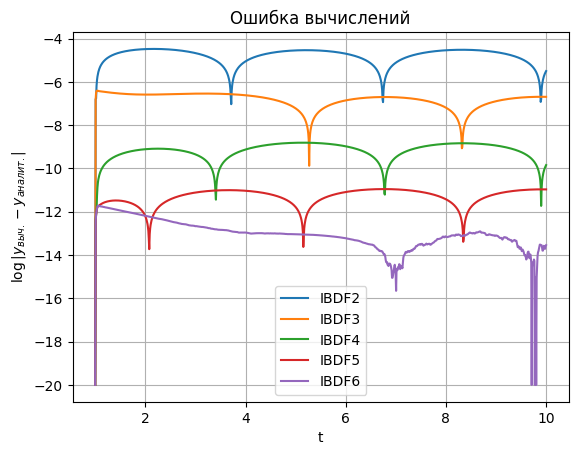

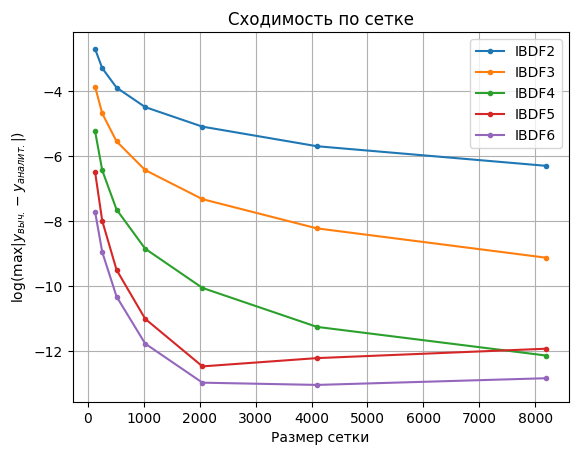

In [140]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [IBDF2, IBDF3, IBDF4, IBDF5, IBDF6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

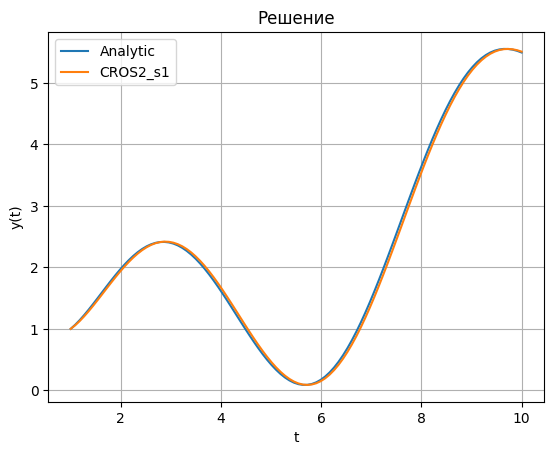

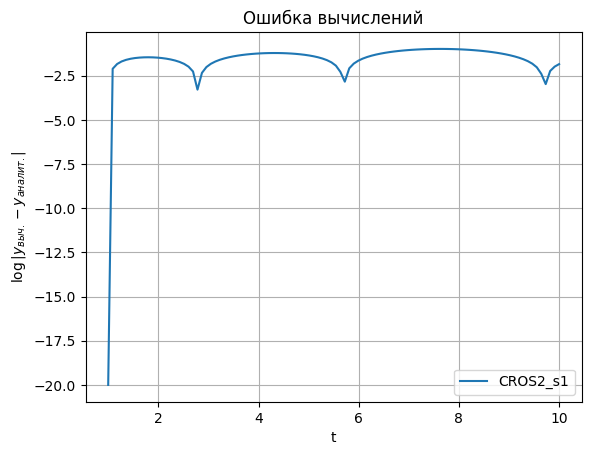

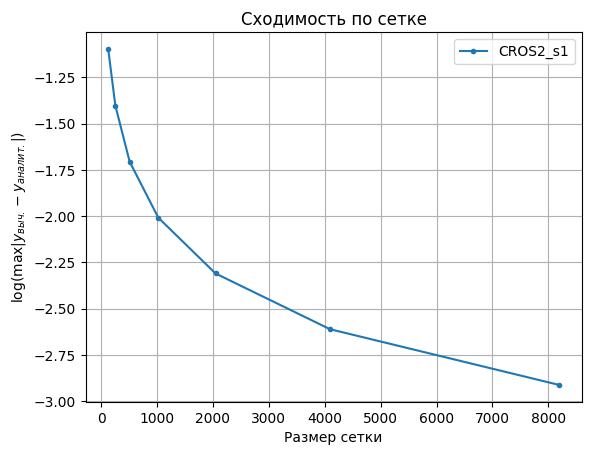

In [177]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e2)+1
methods = [CROS2_s1]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

# Представление Нордсика

Начальное значение вектора Нордсика $z_0 = (y_0, 0, \dots, 0)$. Хотя метод самостартующий, но порядок аппроксимации из-за такого приближения понизился. Поэтому при таком приближении не имеет смысла использовать методы порядка выше 1.

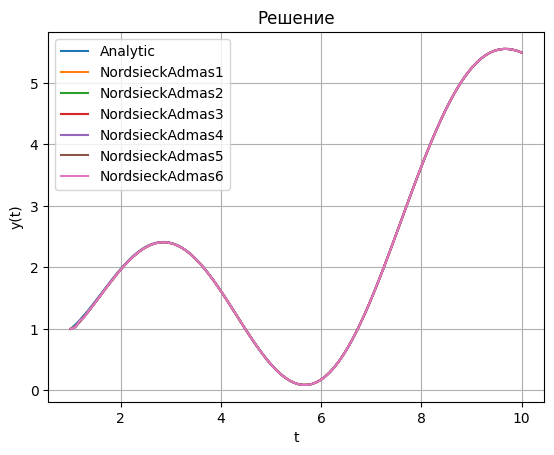

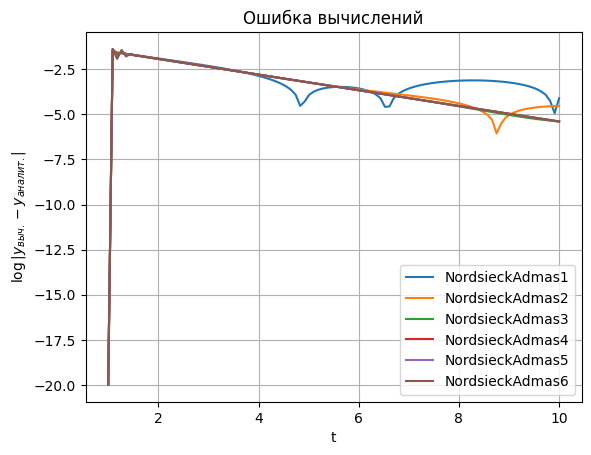

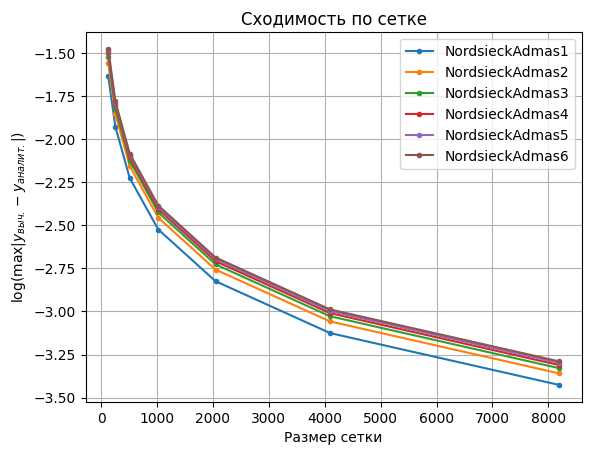

In [48]:
# Не запускай меня.
# Если хочешь запустить, то убери в векторе Нордсика zn в начальном приближении все члены, кроме y0:
# zn[0] = y0
return
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e2)+1
methods = [NordsieckAdams1, NordsieckAdams2, NordsieckAdams3, NordsieckAdams4, NordsieckAdams5, NordsieckAdams6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

Начальное значение вектора Нордсика $z_0 = (y_0, \tau f(x_0, y_0), 0, \dots, 0)$. По графикам видно, что методы более высокого порядка стали точнее, но всё равно они хуже, чем метод 1 порядка.

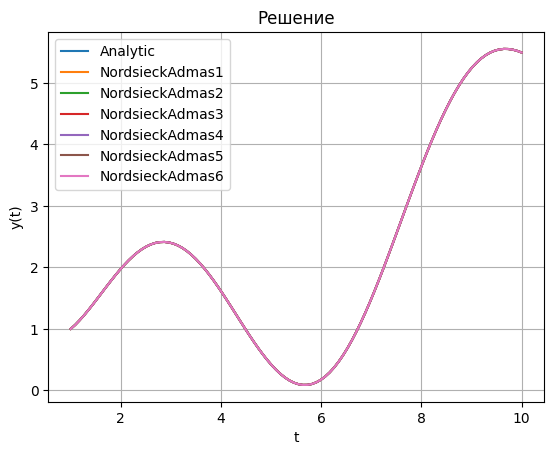

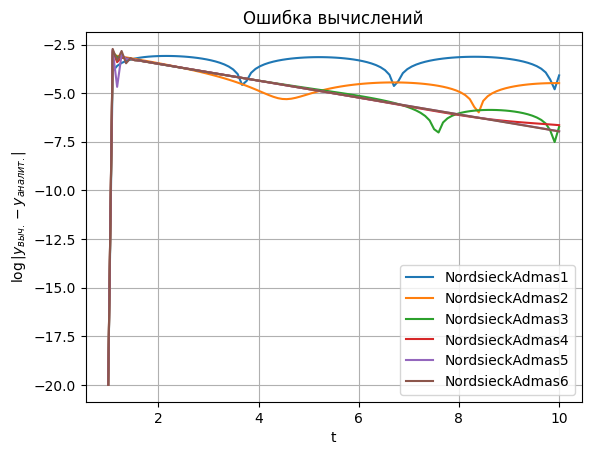

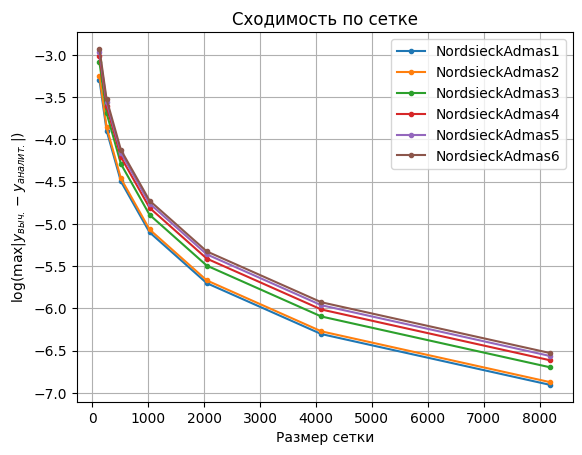

In [51]:
# Не запускай меня.
# Если хочешь запустить, то убери в векторе Нордсика zn в начальном приближении все члены, кроме;
# zn[0] = y0
# zn[1] = tau * funct(t0, y0)
return
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e2)+1
methods = [NordsieckAdams1, NordsieckAdams2, NordsieckAdams3, NordsieckAdams4, NordsieckAdams5, NordsieckAdams6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

При полном заполнении $z_0 = (y_0, \tau y_0', \dots, \frac{\tau^k}{k!} y_0^{(k)})$ методы более высокого порядка становятся точнее методов низкого порядка при одном и том же шаге по времени. 

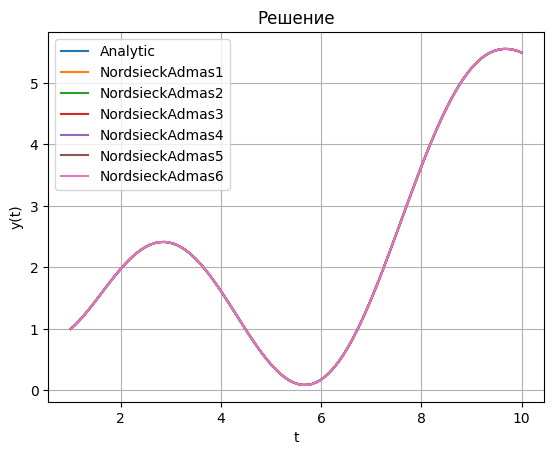

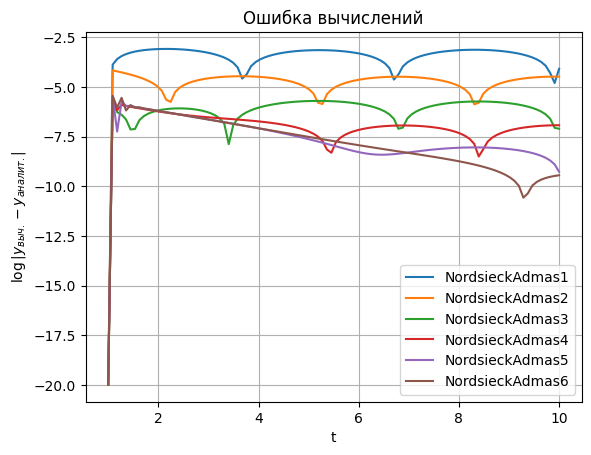

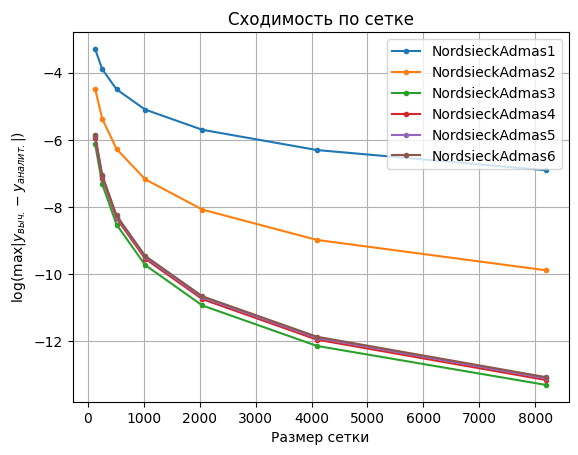

In [75]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e2)+1
methods = [NordsieckAdams1, NordsieckAdams2, NordsieckAdams3, NordsieckAdams4, NordsieckAdams5, NordsieckAdams6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

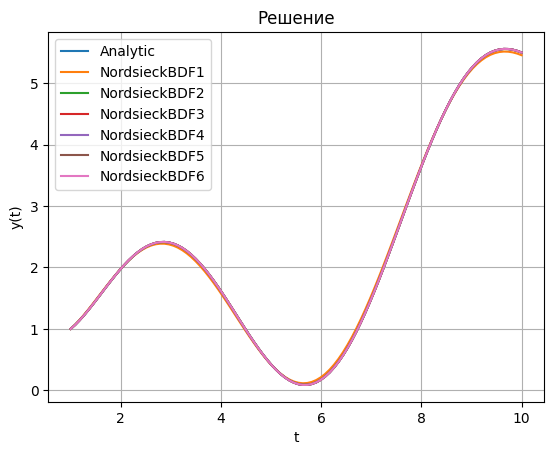

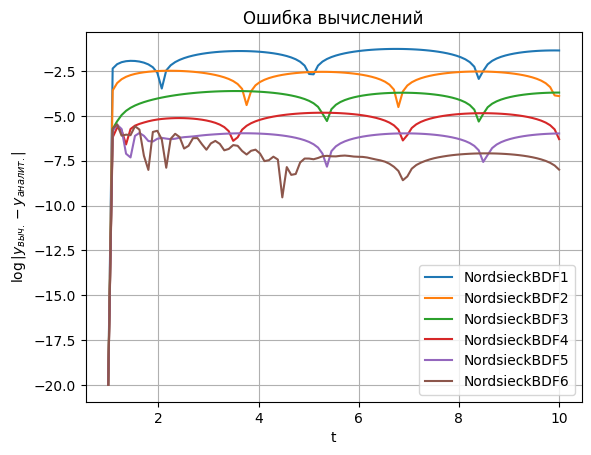

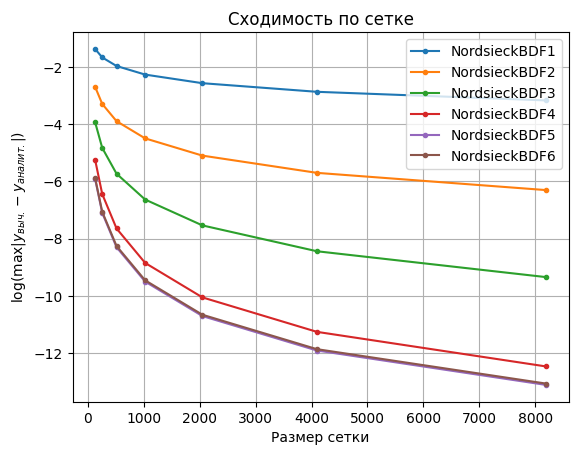

In [77]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e2)+1
methods = [NordsieckBDF1, NordsieckBDF2, NordsieckBDF3, NordsieckBDF4, NordsieckBDF5, NordsieckBDF6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution, SimpleEquationFunction)

# Тестирование на другом ОДУ

Простое обыкновенное дифференциальное уравнение:
$$
y' = Ax^4 + Bx^3 + Cx^2 + Dx + E
$$
$$
y'(0) = y_0
$$
Простейшее аналитическое решение:
$$
y(x) = \frac{A}{5} x^5 + \frac{B}{4} x^4 + \frac{C}{3} x^3 + \frac{D}{2} x^2 + Ex + Const
$$
$$
Const = y_0 - \left( \frac{A}{5} x_0^5 + \frac{B}{4} x_0^4 + \frac{C}{3} x_0^3 + \frac{D}{2} x_0^2 + Ex_0 \right)
$$

In [78]:
A2 = 0.01
B2 = -0.2
C2 = 2
D2 = -3
E2 = 0.5

def SimpleEquationFunction2(x, y):
    global A2, B2, C2, E2, D2
    return A2 * x**4 + B2 * x**3 + C2 * x**2 + D2 * x + E2

def SimpleEquationAnalyticFreePart2(x):
    global A2, B2, C2, E2, D2
    return A2/5 * x**5 + B2/4 * x**4 + C2/3 * x**3 + D2/2 * x**2 + E2 * x

def SimpleEquationConst2(x0, y0):
    return y0 - SimpleEquationAnalyticFreePart2(x0)

def SimpleEquationAnalyticalSolution2(x, x0, y0):
    return SimpleEquationConst2(x0, y0) + SimpleEquationAnalyticFreePart2(x)

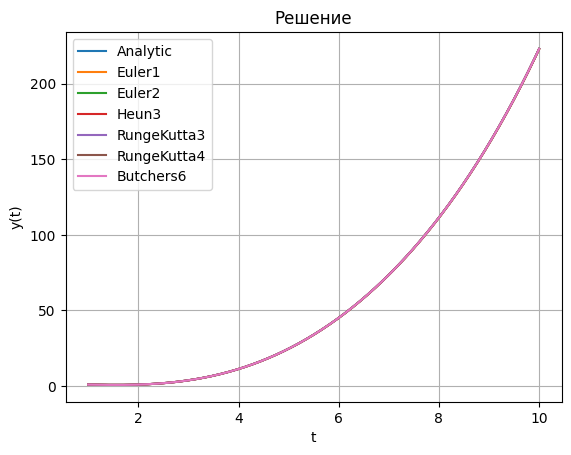

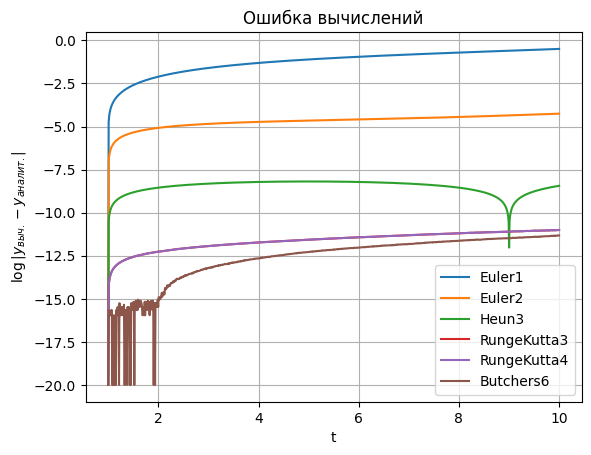

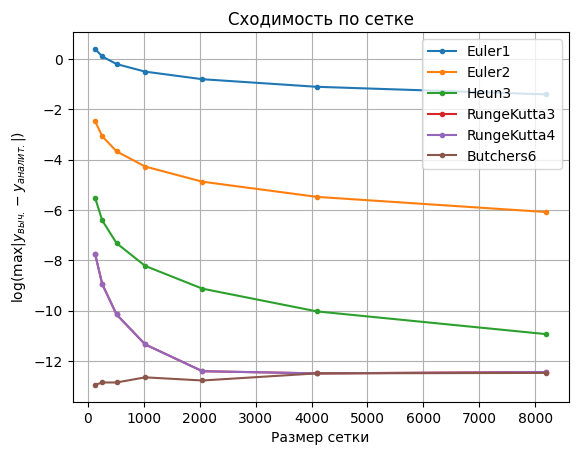

In [24]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [Euler1, Euler2, Heun3, RungeKutta3, RungeKutta4, Butchers6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

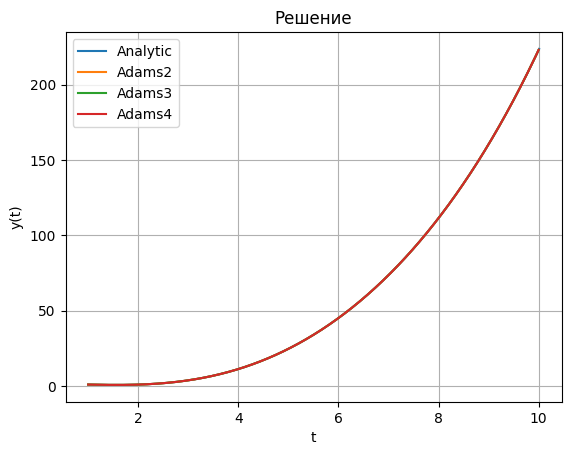

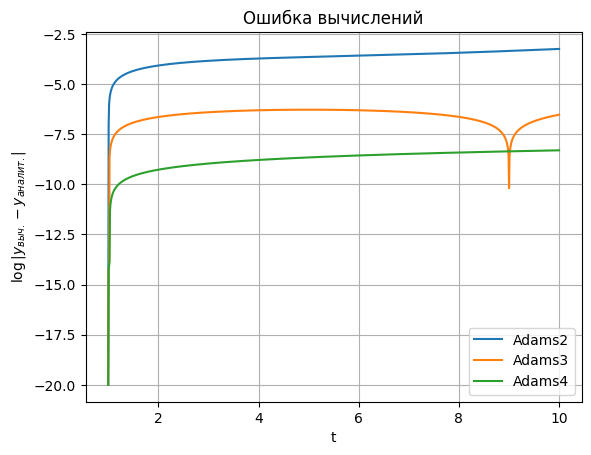

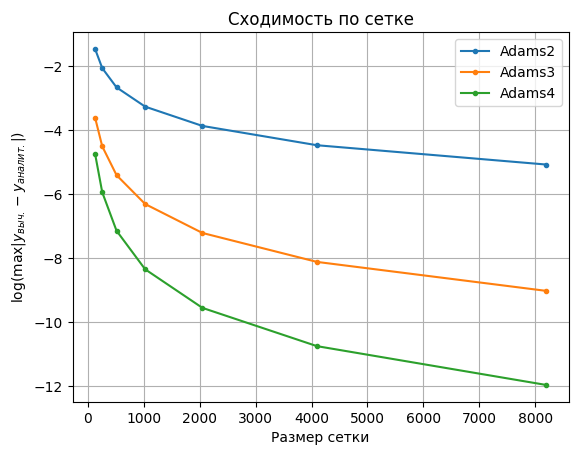

In [25]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [Adams2, Adams3, Adams4]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

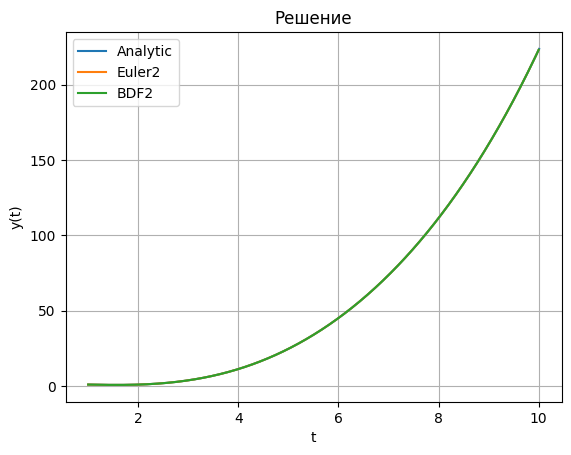

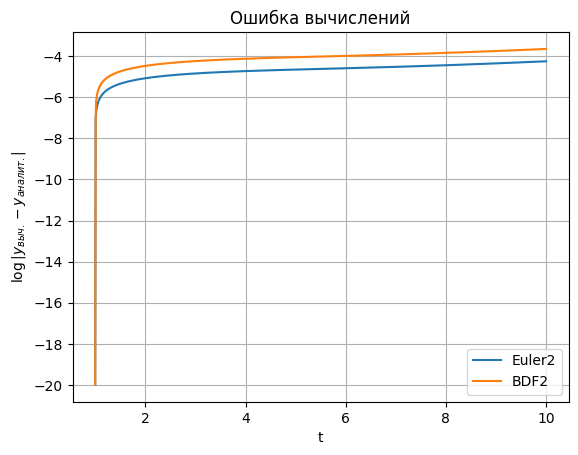

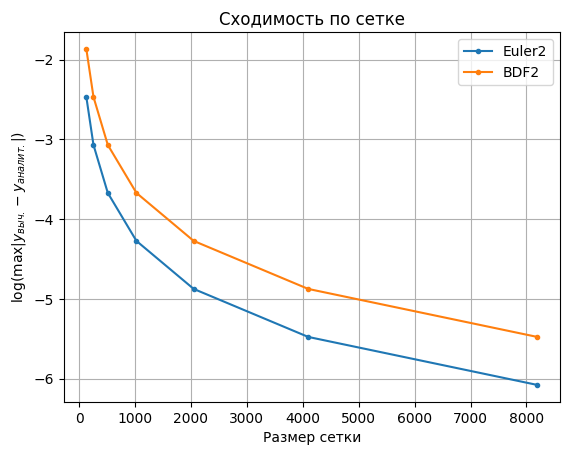

############## Неустойчивость явной ФДН 3 порядка. ##############


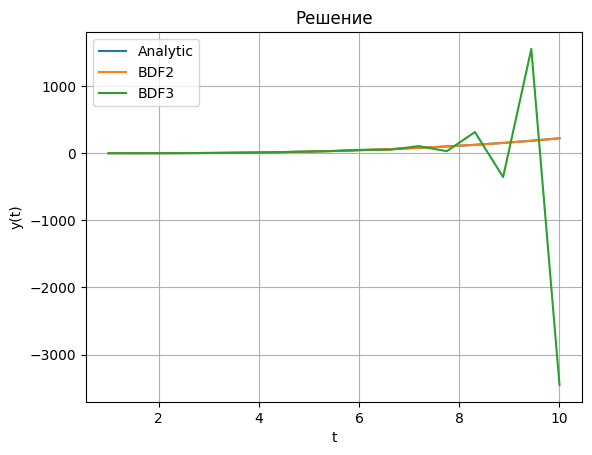

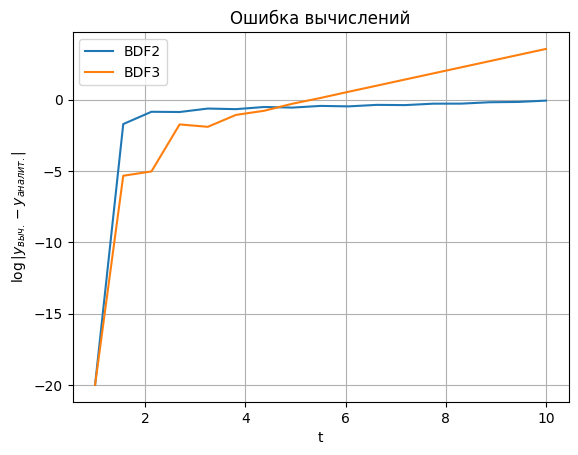

In [136]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [Euler2, BDF2]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

print("############## Неустойчивость явной ФДН 3 порядка. ##############")
Test(t0, t1, y0, 16, [BDF2, BDF3], SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

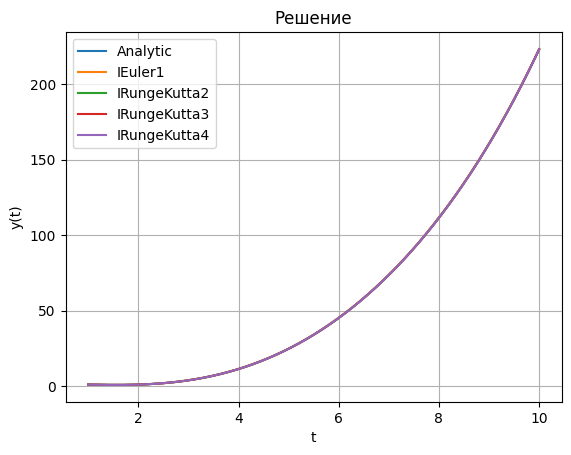

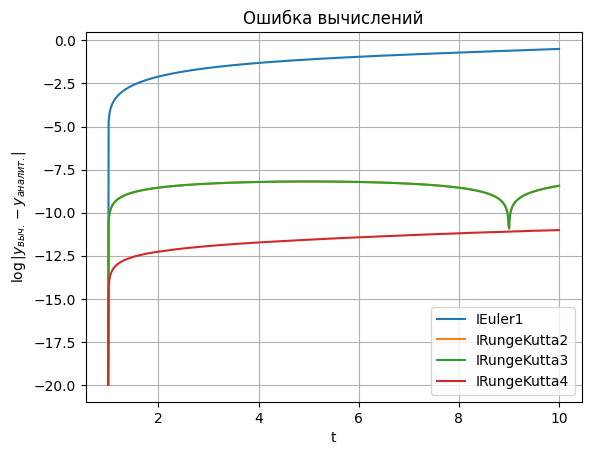

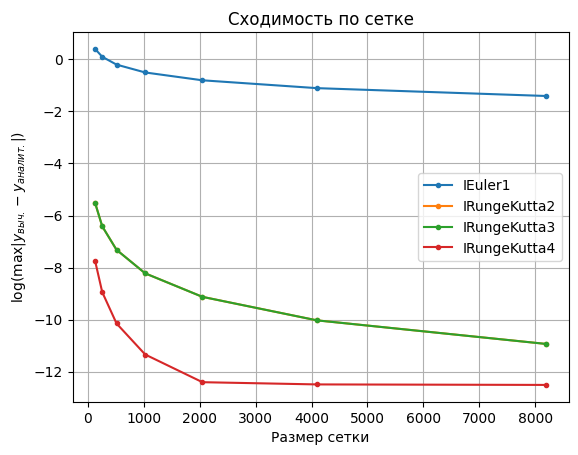

In [137]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)+1
methods = [IEuler1, IRungeKutta2, IRungeKutta3, IRungeKutta4]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

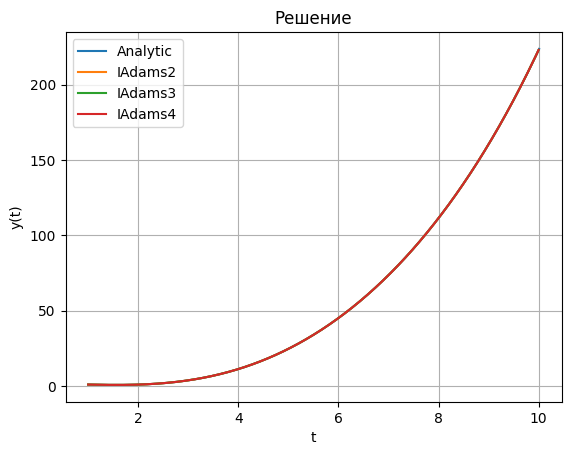

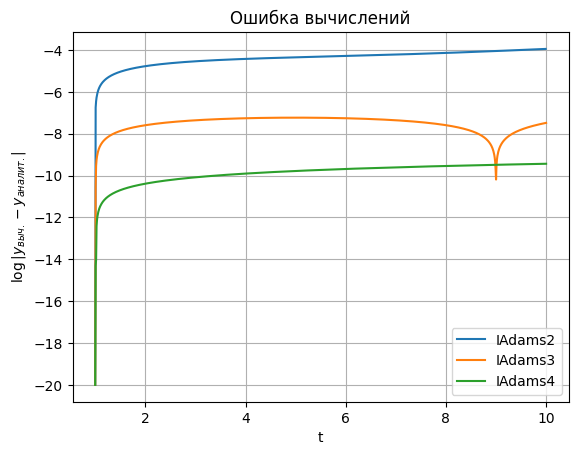

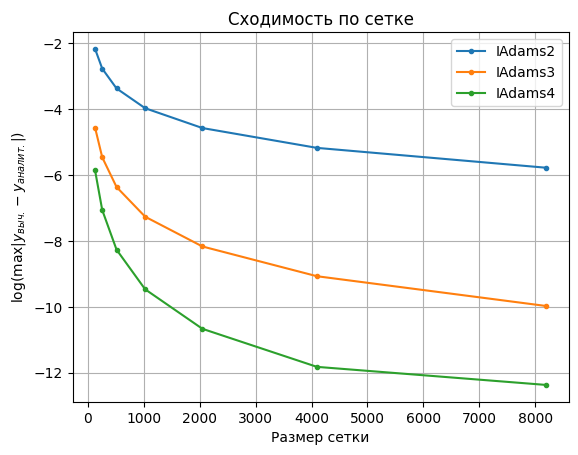

In [138]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [IAdams2, IAdams3, IAdams4]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

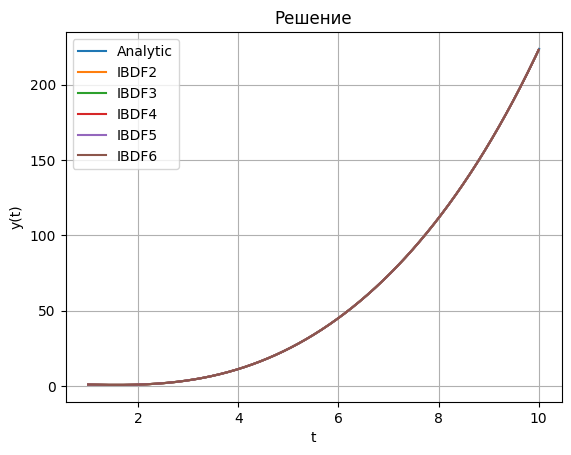

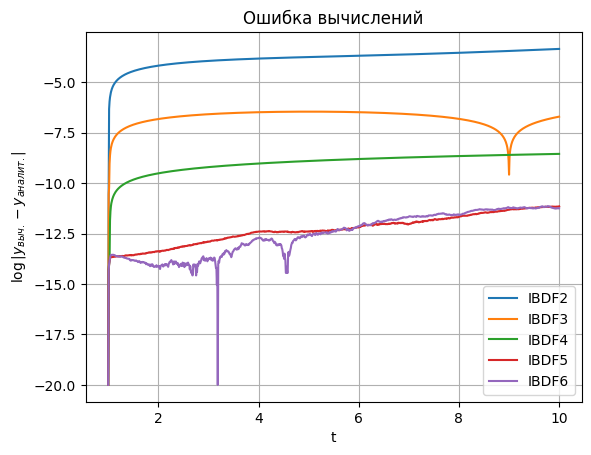

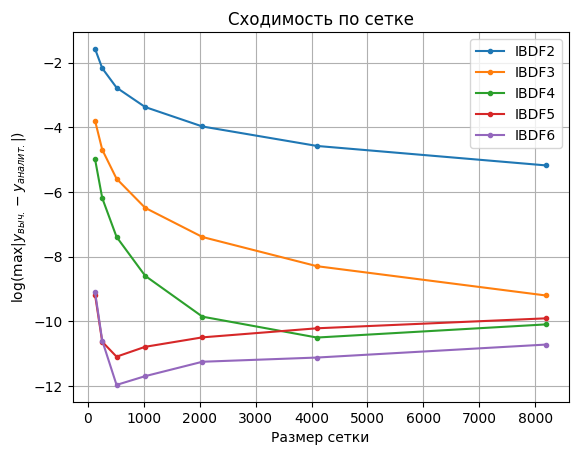

In [139]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [IBDF2, IBDF3, IBDF4, IBDF5, IBDF6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

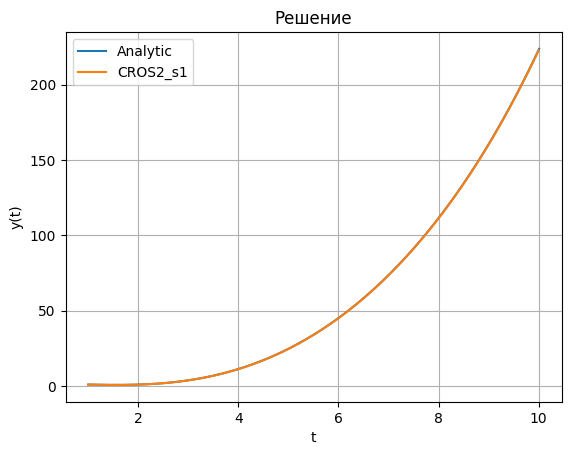

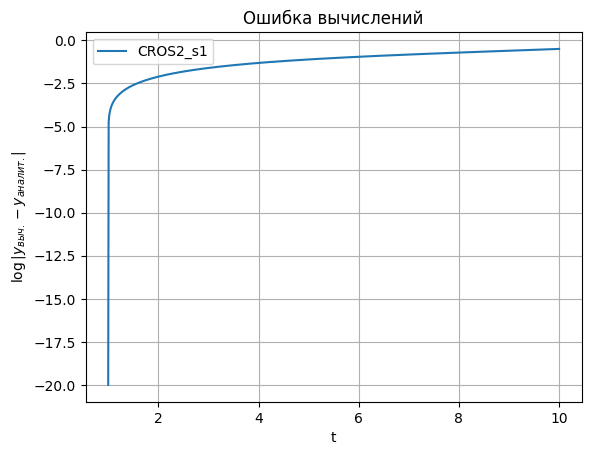

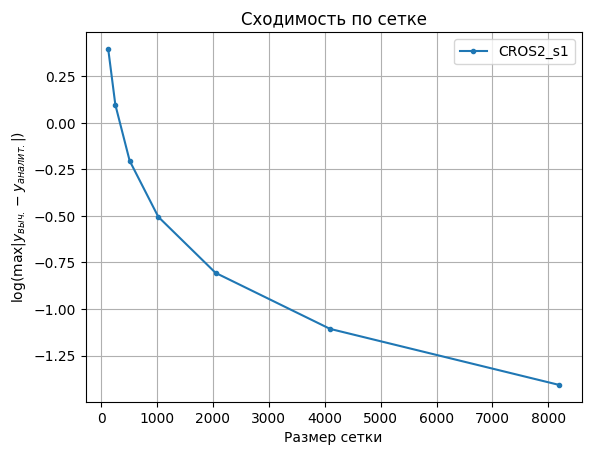

In [179]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [CROS2_s1]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

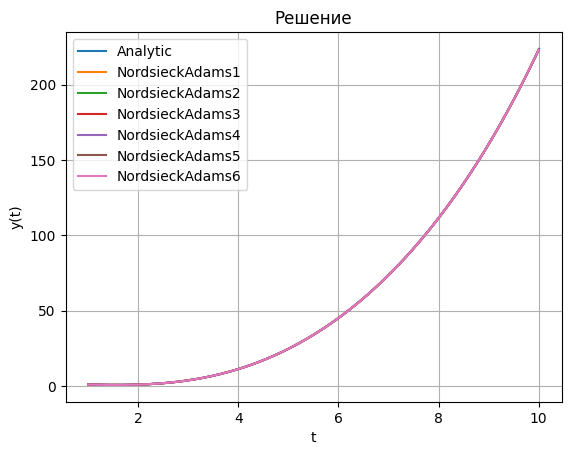

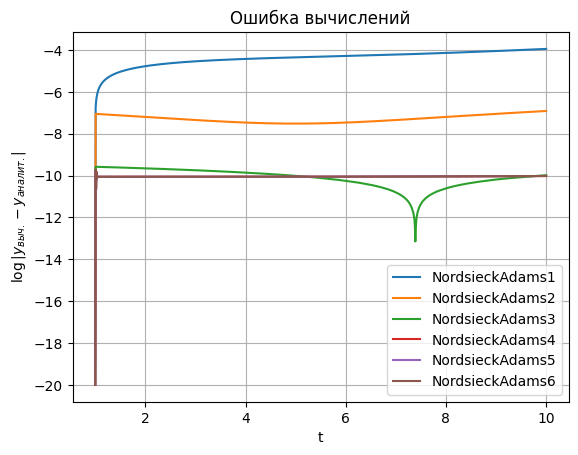

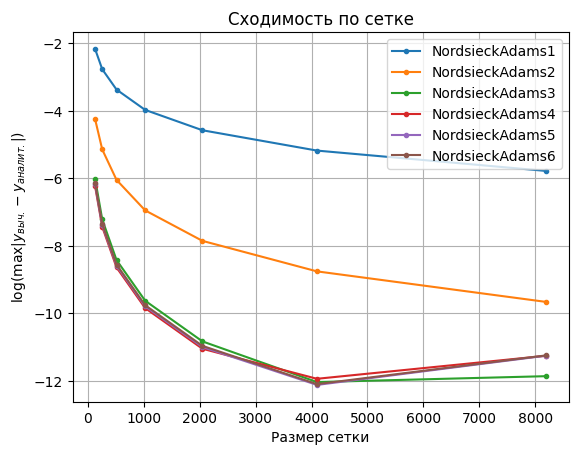

In [79]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [NordsieckAdams1, NordsieckAdams2, NordsieckAdams3, NordsieckAdams4, NordsieckAdams5, NordsieckAdams6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

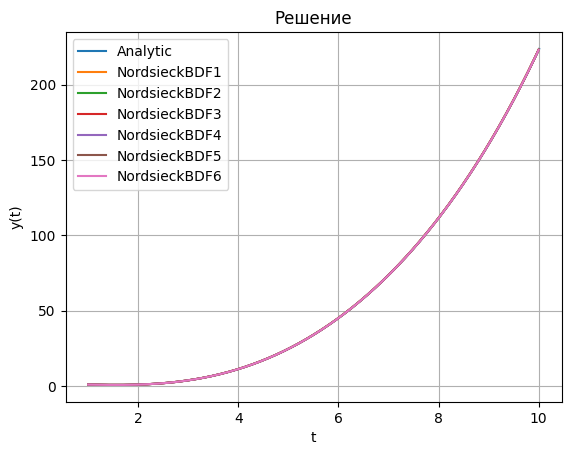

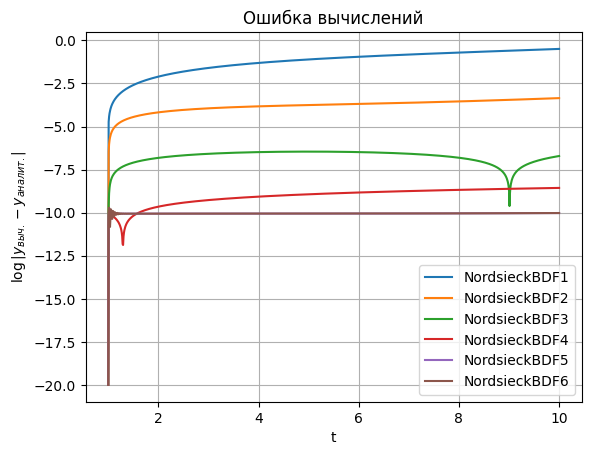

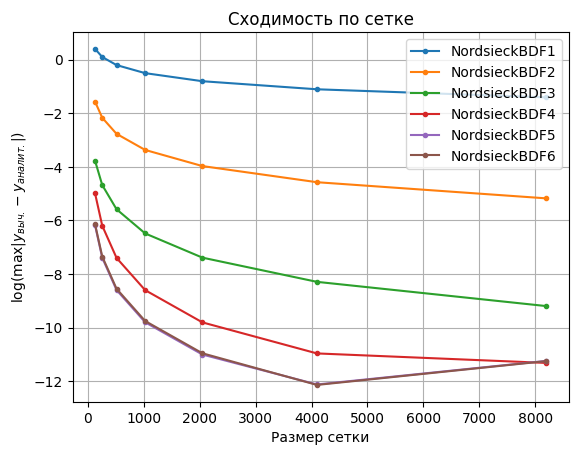

In [80]:
t0 = 1
t1 = 10
y0 = 1
stepsCount = int(1e3)
methods = [NordsieckBDF1, NordsieckBDF2, NordsieckBDF3, NordsieckBDF4, NordsieckBDF5, NordsieckBDF6]
Test(t0, t1, y0, stepsCount, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)
TestGrid(t0, t1, y0, methods, SimpleEquationAnalyticalSolution2, SimpleEquationFunction2)

# Тестирование на системе ОДУ

Задача Коши:
$$
\begin{equation*}
    \begin{cases}
        x' = x - 2 y \\
        y' = 2 x + 6 y
    \end{cases}
\end{equation*}
$$
$$
\begin{equation*}
    \begin{cases}
        x(t_0) = x_0 \\
        y(t_0) = y_0
    \end{cases}
\end{equation*}
$$

Аналитическое решение:
$$
\begin{equation*}
    \begin{bmatrix} x(t) \\ y(t) \end{bmatrix} = C_1 e^{5t} \begin{bmatrix} -1 \\ 2 \end{bmatrix} + C_2 e^{2t} \begin{bmatrix} 2 \\ -1\end{bmatrix}
\end{equation*}
$$
$$
\begin{equation*}
    \begin{bmatrix} C_1 \\ C_2 \end{bmatrix} = \frac{1}{3}e^{-7t_0} \begin{bmatrix} e^{2t_0} (x_0 + y_0) \\ e^{5t_0} (2x_0 + y_0)\end{bmatrix}
\end{equation*}
$$

In [125]:
def TestSystem(t0, t1, y0, stepsCount, methods, equRefSol, equFunct):
    tau = (t1 - t0) / stepsCount

    tref = numpy.arange(t0, t1 + tau, tau)
    yref = equRefSol(tref, t0, y0)

    t = []
    y = []

    for st in range(0, len(methods)):
        ti, yi = methods[st](t0, y0, tau, stepsCount, equFunct)
        t.append(numpy.copy(ti))
        y.append(numpy.copy(yi))

        # print("ti\n", ti)
        # print("yi\n", yi)

    plt.title("Решение")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    # print("tref\n", tref)
    # print("yref\n", yref)
    BuildPlot(tref, yref)
    for st1 in range(0, len(y[st][0])):
        plt.plot(tref, yref[:, st1], label = f"Ref[{st1}]")

    for st in range(0, len(methods)):
        for st1 in range(0, len(y[st][0])):
            plt.plot(t[st], y[st][:, st1], label = f"{methods[st].__name__}[{st1}]")
    plt.grid()
    plt.legend()
    plt.show()

    plt.title("Ошибка вычислений")
    plt.xlabel("t")
    plt.ylabel("$\log{|y_{выч.} - y_{аналит.}|}$")
    for st in range(0, len(methods)):
        res = numpy.log10(numpy.abs(equRefSol(t[st], t0, y0) - y[st]) + 1e-20)
        for st1 in range(0, len(y[st][0])):
            plt.plot(t[st], res[:, st1], label = f"{methods[st].__name__}[{st1}]")
    plt.grid()
    plt.legend()
    plt.show()

def TestSystemGrid(t0, t1, y0, methods,
             equRefSol, equFunct, 
             stepsStart = 128, stepsStop = 2048*4, 
             BuildSolutionPlots = False, stepsCountSolPlot = 1e3):

    res = []
    for st in range(0, len(methods)):
        res.append([])
    steps = []
    
    if (BuildSolutionPlots):
        tau = (t1 - t0) / stepsCountSolPlot
        tref = numpy.arange(t0, t1 + tau, tau)
        yref = equRefSol(tref, t0, y0)
        plt.title("Сходимость по сетке")
        plt.plot(tref, yref, marker = '.', label = "Аналит.")

    while (stepsStart <= stepsStop):
        for st in range(0, len(methods)):
            tau = (t1 - t0) / stepsStart
            _t, _y = methods[st](t0, y0, tau, stepsStart, equFunct)

            if (BuildSolutionPlots):
                plt.plot(_t, _y, marker = '.', label = f"{methods[st].__name__}, {stepsStart}")

            _res = equRefSol(_t, t0, y0) - _y

            res[st].append(math.log10(Norms.NormV1(_res)))
        steps.append(stepsStart)
        stepsStart *= 2
    
    if (BuildSolutionPlots):
        plt.grid()
        plt.legend()
        plt.show()

    plt.title("Сходимость по сетке")
    plt.xlabel("Размер сетки")
    plt.ylabel("$\log (\max |{y_{выч.} - y_{аналит.}}|)$")
    for st in range(0, len(methods)):
        plt.plot(steps, res[st], marker = '.', label = methods[st].__name__)
    plt.grid()
    plt.legend()
    plt.show()

    if (False):
        plt.title("Сходимость по сетке\nв двойном логарифмическом масштабе")
        plt.xlabel("log(размер сетки)")
        plt.ylabel("$\log (\max |{y_{выч.} - y_{аналит.}}|) + offset$")
        for st in range(0, len(methods)):
            plt.plot(numpy.log2(steps), numpy.array(res[st]) - res[st][0], marker = '.', label = methods[st].__name__)
        plt.grid()
        plt.legend()
        plt.show()

In [126]:
def EquationSystem3(t, x):
    return numpy.matmul(numpy.array([[1, -2], [2, 6]]), x)

def EquationSystemAnalyticalSolution3(t, t0, x0):
    C1 = 1/3 * math.exp(-5 * t0) * (x0[0] + 2 * x0[1])
    C2 = 1/3 * math.exp(-2 * t0) * (2 * x0[0] + x0[1])
    return C1 * numpy.dot(numpy.exp(5 * t).reshape(-1, 1), numpy.array([[-1, 2]])) + C2 * numpy.dot(numpy.exp(2 * t).reshape(-1, 1), numpy.array([[2, -1]]))

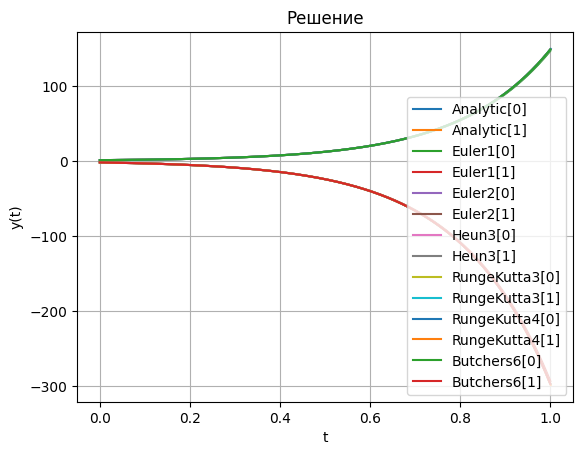

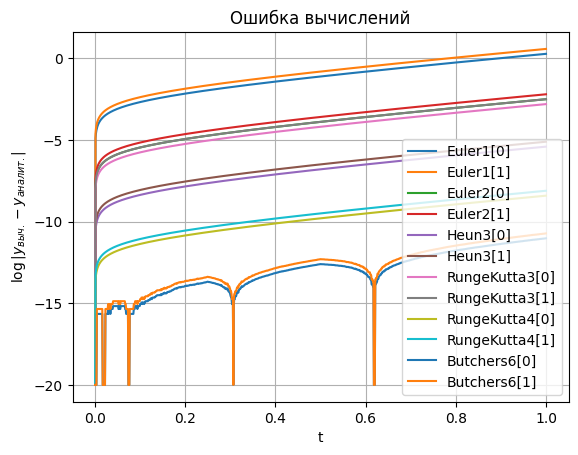

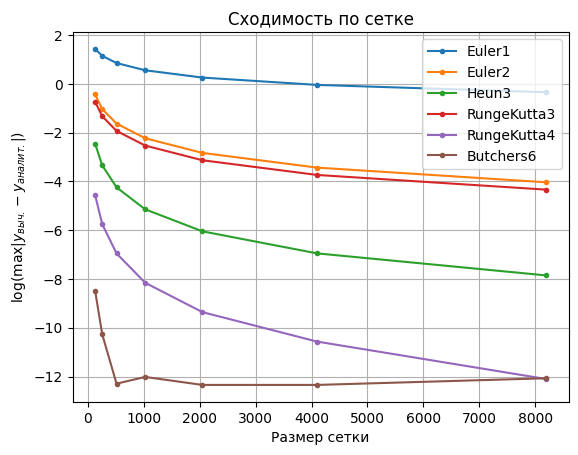

In [143]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(1e3)+1
methods = [Euler1, Euler2, Heun3, RungeKutta3, RungeKutta4, Butchers6]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3)

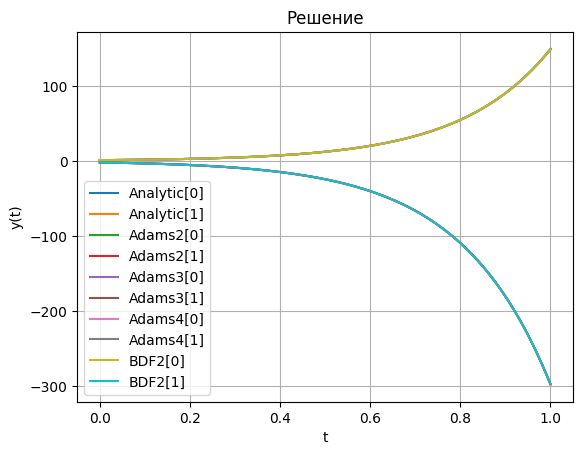

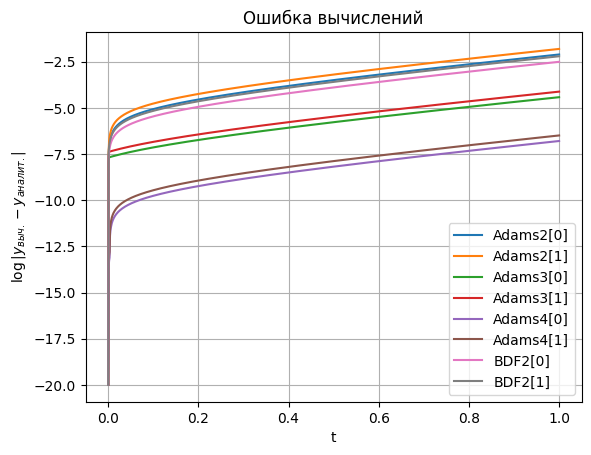

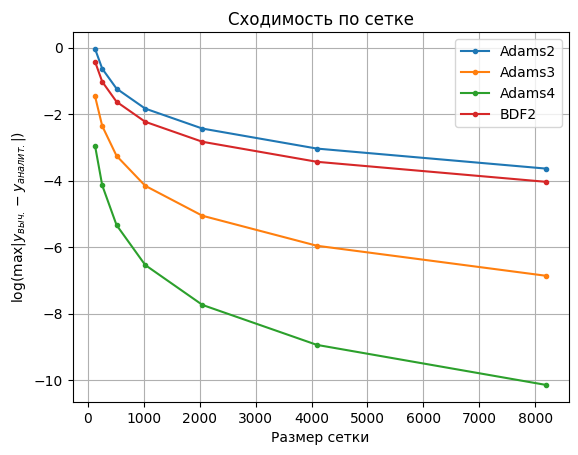

In [144]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(1e3)+1
methods = [Adams2, Adams3, Adams4, BDF2]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3)

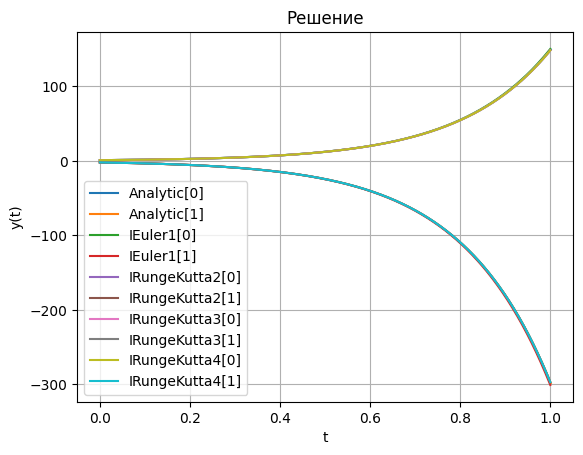

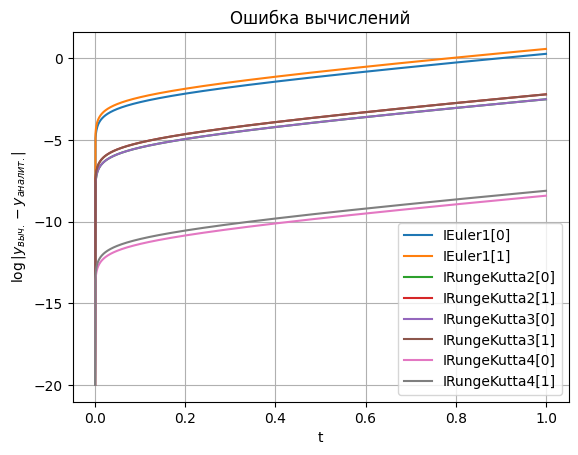

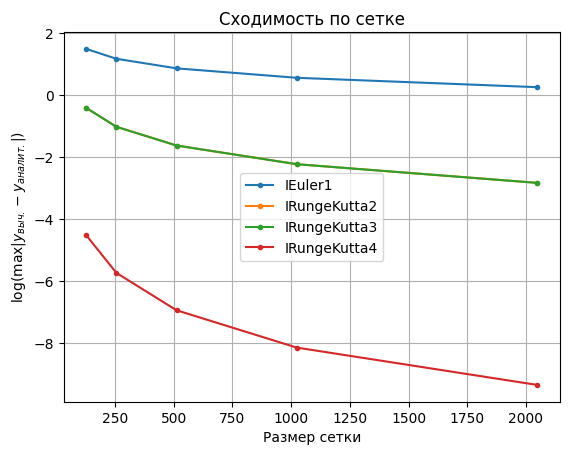

In [145]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(1e3)+1
methods = [IEuler1, IRungeKutta2, IRungeKutta3, IRungeKutta4]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3, stepsStop=2048)

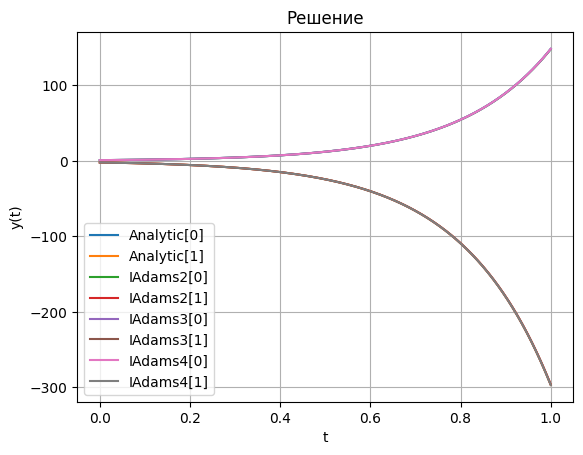

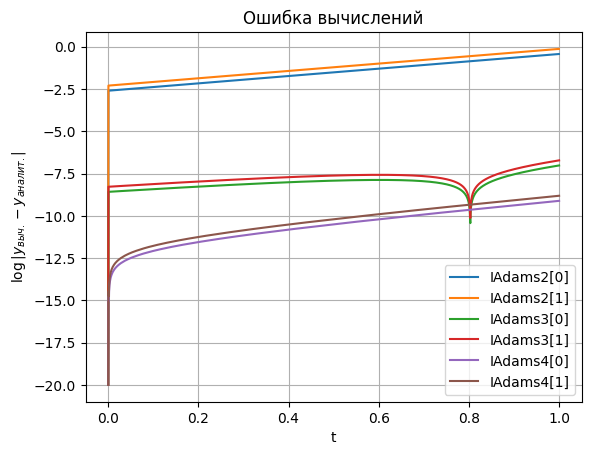

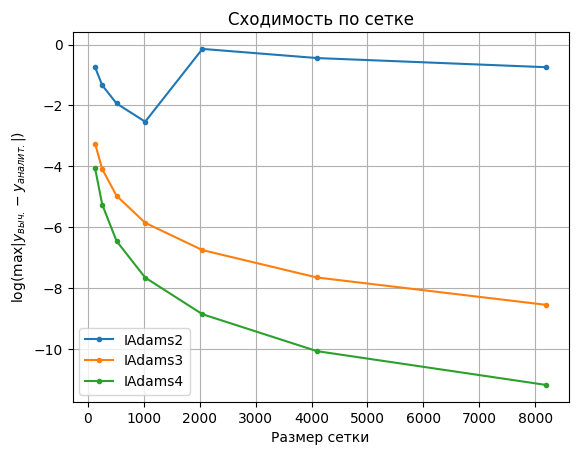

In [202]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(2e3)+1
methods = [IAdams2, IAdams3, IAdams4]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3)

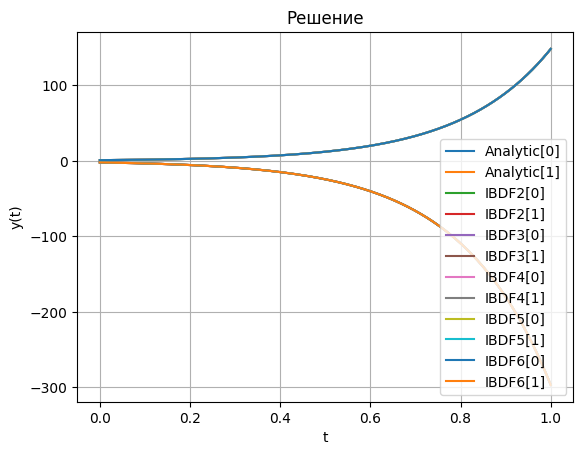

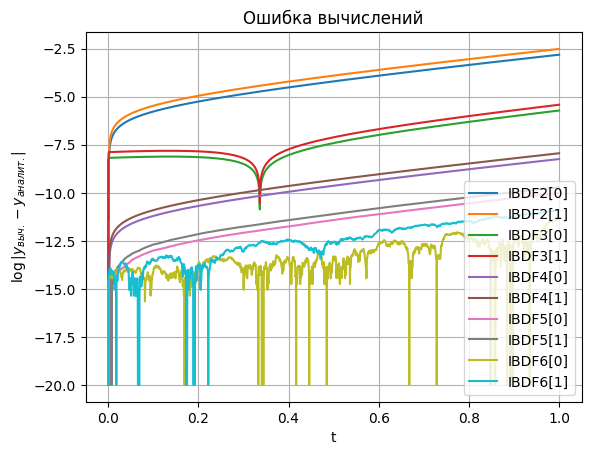

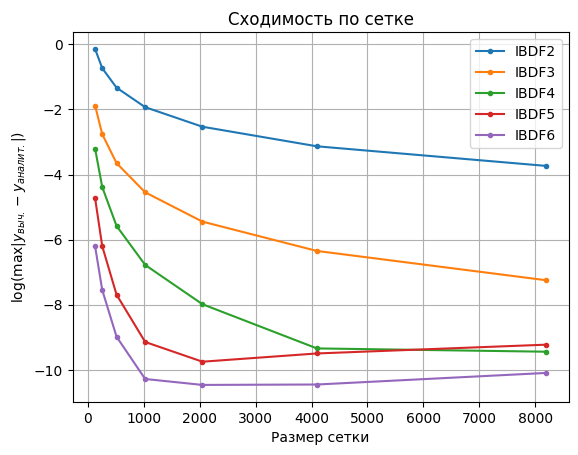

In [150]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(2e3)+1
methods = [IBDF2, IBDF3, IBDF4, IBDF5, IBDF6]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3)

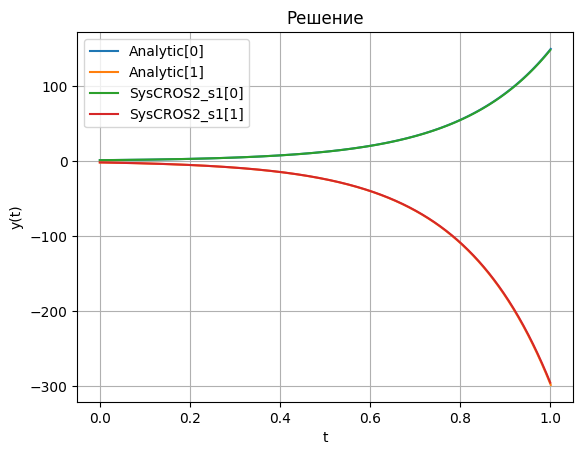

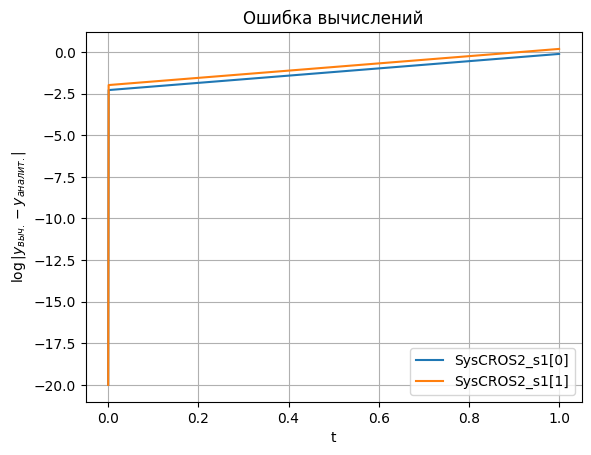

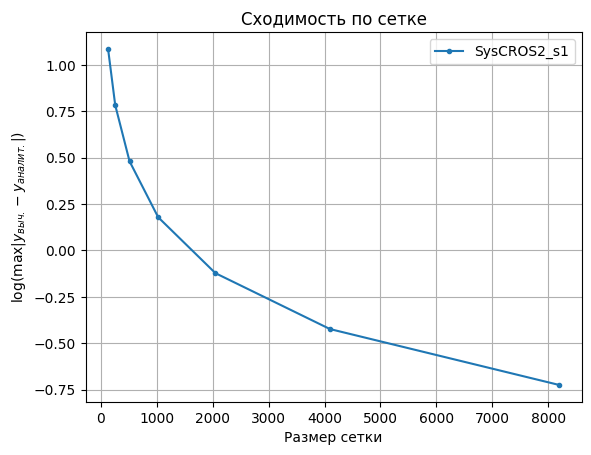

In [181]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(1e3)+1
methods = [SysCROS2_s1]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3)

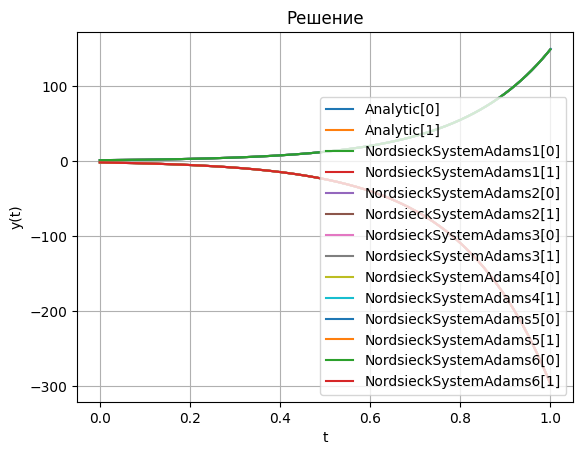

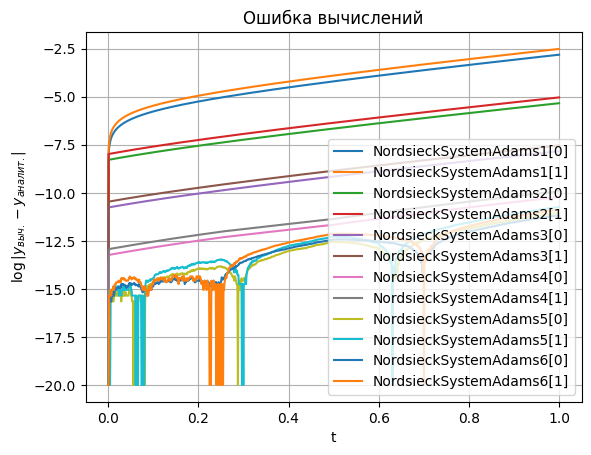

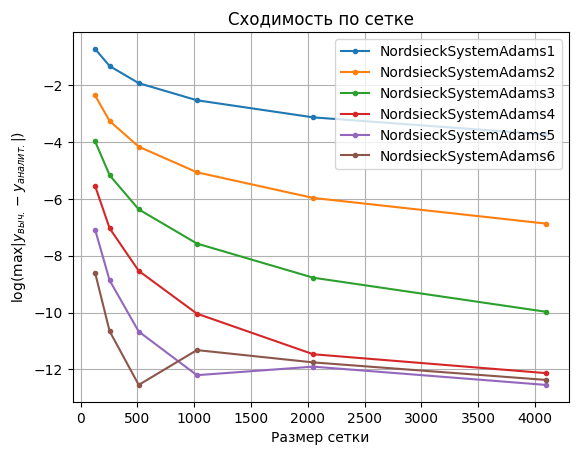

In [233]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(1e3)+1
methods = [NordsieckSystemAdams1, NordsieckSystemAdams2, NordsieckSystemAdams3, NordsieckSystemAdams4, NordsieckSystemAdams5, NordsieckSystemAdams6]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3, stepsStop = 2048*2)

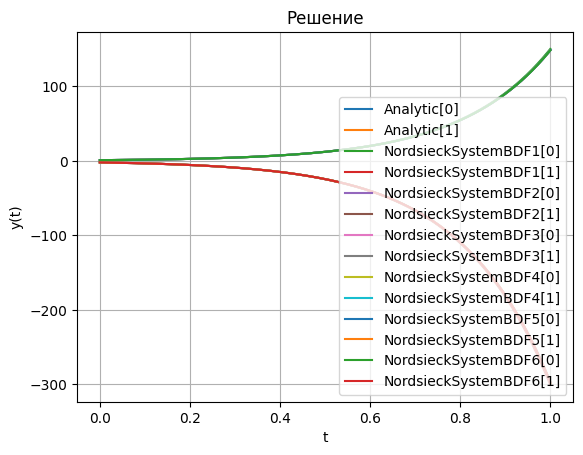

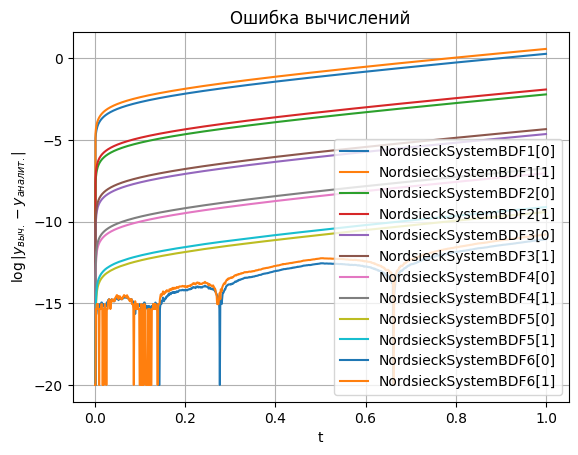

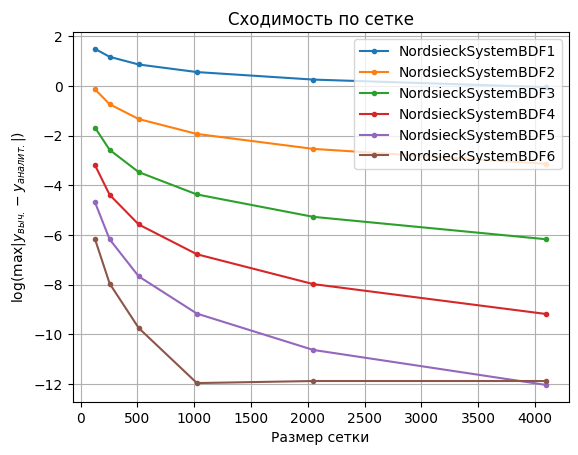

In [234]:
t0 = 0
t1 = 1
x0 = numpy.array([1, -2])
stepsCount = int(1e3)+1
methods = [NordsieckSystemBDF1, NordsieckSystemBDF2, NordsieckSystemBDF3, NordsieckSystemBDF4, NordsieckSystemBDF5, NordsieckSystemBDF6]
Test(t0, t1, x0, stepsCount, methods, EquationSystemAnalyticalSolution3, EquationSystem3)
TestGrid(t0, t1, x0, methods, EquationSystemAnalyticalSolution3, EquationSystem3, stepsStop = 2048*2)

# VIII.11. Вариант 3

$$
\begin{equation}
    \begin{cases}
        x' = y \\
        y' = x^2 - 1
    \end{cases}
\end{equation}
$$

Особые точки (1, 0), (-1, 0).

In [238]:
def RunTask(t0, t1, x0, stepsCount, methods, funct):
    tau = (t1 - t0) / stepsCount

    t = []
    y = []

    for st in range(0, len(methods)):
        ti, yi = methods[st](t0, x0, tau, stepsCount, funct)
        t.append(numpy.copy(ti))
        y.append(numpy.copy(yi))

    plt.title(f"Решение системы $t = {t1}$. $x({t0}) = {x0[0]}$, $y({t0}) = {x0[1]}$.")
    plt.xlabel("t")
    plt.ylabel(r"$\overrightarrow{x}(t)$")
    for st in range(0, len(methods)):
        BuildPlot(t[st], y[st], methods[st].__name__)
    plt.grid()
    plt.legend()
    plt.show()
    return numpy.array(t), numpy.array(y)
    
class Dict:
    def __init__(self, t0, t1, x0):
        self.t0 = t0
        self.t1 = t1
        self.x0 = numpy.array(x0)

def BuildPhaseTraces(dict, stepsCount, method, funct):
    plt.title("Фазовые траектории системы y(x).")
    plt.xlabel("x")
    plt.ylabel("y")
    for st in range(0, len(dict)):
        tau = (dict[st].t1 - dict[st].t0) / stepsCount
        t, y = method(dict[st].t0, dict[st].x0, tau, stepsCount, funct)
        plt.plot(y[:, 0], y[:, 1], color = "blue")
        plt.plot(dict[st].x0[0], dict[st].x0[1], marker='.', color = "blue")
    plt.grid()
    plt.show()

In [239]:
def TaskSystem1(t, x):
    return numpy.array([x[1], x[0]**2 - 1])

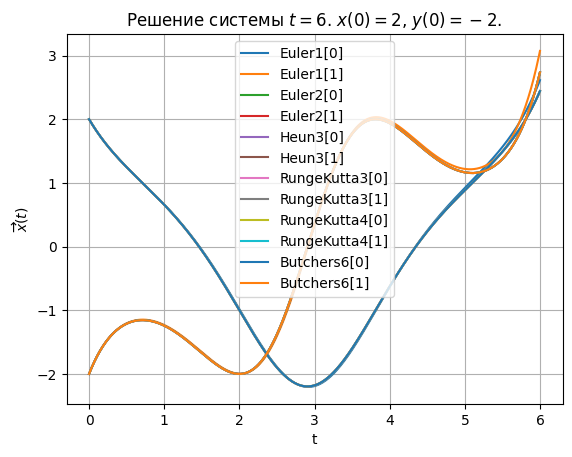

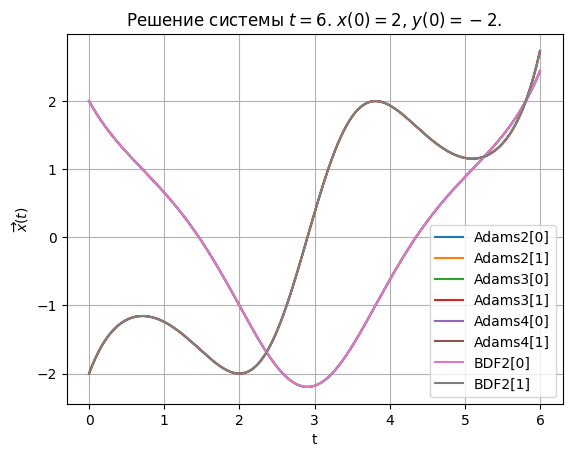

In [268]:
methods = [Euler1, Euler2, Heun3, RungeKutta3, RungeKutta4, Butchers6]
RunTask(0, 6, numpy.array([2, -2]), int(1e3), methods, TaskSystem1)

methods = [Adams2, Adams3, Adams4, BDF2]
RunTask(0, 6, numpy.array([2, -2]), int(1e3), methods, TaskSystem1)

### Фазовые траектории системы. Строить их разными методами бесполезно, так как картинки получаются похожими

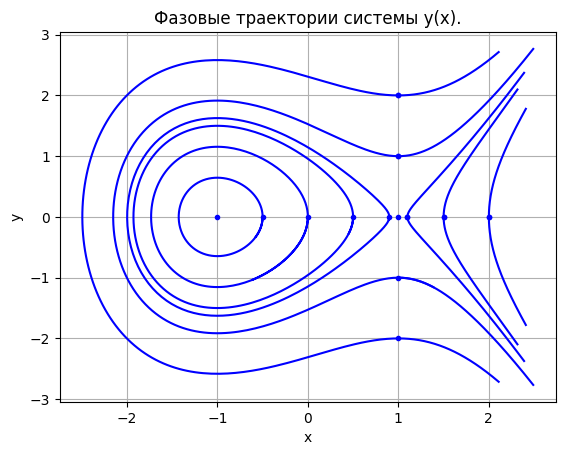

In [265]:
dict = [
    Dict(0, 6, [0, 0]),
    Dict(0, 6, [0.5, 0]),
    Dict(0, 6, [1, 0]),
    Dict(0, 1, [-1, 0]),
    Dict(0, 5, [-0.5, 0]),

    Dict(0, 8, [0.9, 0]),

    Dict(0, 2.2, [1.1, 0]),
    Dict(0, -2.2, [1.1, 0]),

    Dict(0, 1, [1.5, 0]),
    Dict(0, -1, [1.5, 0]),

    Dict(0, 0.5, [2, 0]),
    Dict(0, -0.5, [2, 0]),

    Dict(0, 1, [1, 1]),
    Dict(0, -5, [1, 1]),
    Dict(0, -1, [1, -1]),

    Dict(0, 0.5, [1, 2]),
    Dict(0, -3.5, [1, 2]),
    Dict(0, -0.5, [1, -2]),
]
BuildPhaseTraces(dict, int(2e2), Butchers6, TaskSystem1)
# BuildPhaseTraces(dict, int(1e2), Adams4, TaskSystem1)
# BuildPhaseTraces(dict, int(1e2), BDF2, TaskSystem1)

# Задача X.9.11

$$
\begin{equation*}
    \begin{cases}
        y_1' = -1.71 y_1 + 0.43 y_2 + 8.23 y_3 + 0.0007 \\
        y_2' = 1.71y_1 - 8.75y_2 \\
        y_3' = -10.03 y_3 + 0.43 y_4 + 0.035 y_5 \\
        y_4' = 8.32 y_2 + 1.71 y_3 - 1.12 y_4 \\
        y_5' = -1.745 y_5 + 0.43 y_6 + 0.43 y_7 \\
        y_6' = -280 y_6 y_8 + 0.69 y_4 + 1.71 y_5 - 0.43 y_6 + 0.69 y_7 \\
        y_7' = 280 y_6 y_8 - 1.87 y_7 \\
        y_8' = - y_7'
    \end{cases}
\end{equation*}
$$

Начальные условия:
все переменные 0, кроме $y_1(0) = 1$, $y_8(0) = 0.0057$. $T_k = 421.8122$

In [240]:
def Task2(t, y):
    assert(len(y) == 8)
    return numpy.array([
            -1.71* y[0] + 0.43 * y[1] + 8.23 * y[2] + 0.0007, 
            1.71 * y[0] - 8.75 * y[1], 
            -10.03 * y[2] + 0.43 * y[3] + 0.035 * y[4], 
            8.32 * y[1] + 1.71 * y[2] - 1.12 * y[3], 
            -1.745 * y[4] + 0.43 * y[5] + 0.43 * y[6], 
            -280 * y[5] * y[7] + 0.69 * y[3] + 1.71 * y[4] - 0.43 * y[5] + 0.69 * y[6], 
            280 * y[5] * y[7] - 1.87 * y[6], 
            - y[6]
        ])

Task2T1 = 0
Task2T2 = 421.8122
Task2ZeroCond = numpy.array([1, 0, 0, 0, 0, 0, 0, 0.0057])

При решение жесткой системы явными методами наблюдается их неустойчивость. При малых шагах по времени решения "уходят в бесконечность" (становятся по порядку $10^{100}$).

/tmp/ipykernel_13546/1180459465.py:9: RuntimeWarning: overflow encountered in scalar multiply
  -280 * y[5] * y[7] + 0.69 * y[3] + 1.71 * y[4] - 0.43 * y[5] + 0.69 * y[6],
/tmp/ipykernel_13546/1180459465.py:10: RuntimeWarning: overflow encountered in scalar multiply
  280 * y[5] * y[7] - 1.87 * y[6],
/tmp/ipykernel_13546/1180459465.py:8: RuntimeWarning: invalid value encountered in scalar add
  -1.745 * y[4] + 0.43 * y[5] + 0.43 * y[6],
/tmp/ipykernel_13546/658067528.py:71: RuntimeWarning: invalid value encountered in add
  ksum += ButchersTable[st][st1] * k[st1]
/tmp/ipykernel_13546/658067528.py:84: RuntimeWarning: invalid value encountered in multiply
  ysum += ButchersY[st] * k[st]
/tmp/ipykernel_13546/658067528.py:84: RuntimeWarning: invalid value encountered in add
  ysum += ButchersY[st] * k[st]


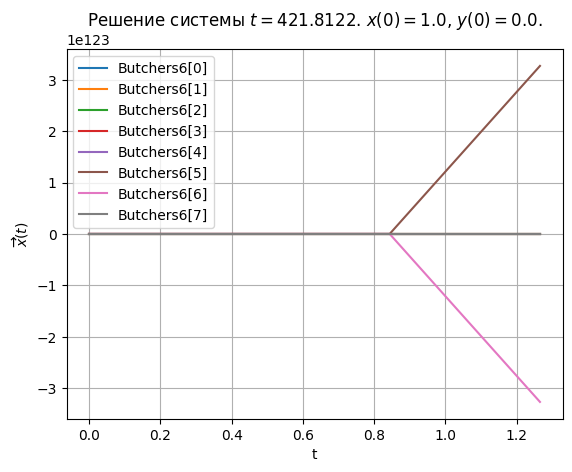

(array([[  0.       ,   0.4218122,   0.8436244, ..., 420.9685756,
         421.3903878, 421.8122   ]]),
 array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  5.70000000e-03],
         [ 9.38338822e-01, -1.38451814e+00, -4.26434432e-01, ...,
          -8.81146996e-02,  1.41729284e-03,  9.26968069e-03],
         [ 1.21933305e+01, -1.58626241e+01, -1.20638965e+01, ...,
           5.76490713e+03, -5.76802157e+03, -2.58129689e+00],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]))

In [18]:
methods = [Butchers6]
RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e3), methods, Task2)

При уменьшении шага в 100 раз (с $10^3$ до $10^5$ точек на рассматриваемом промежутке времени) решение начинает сходиться.

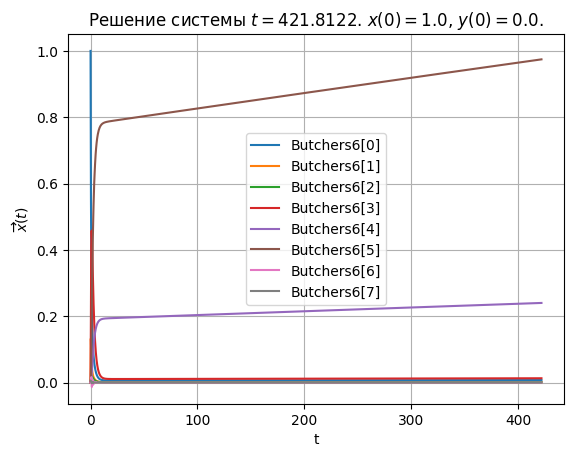

In [189]:
methods = [Butchers6]
task2_b6t, task2_b6y = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e5), methods, Task2)

/tmp/ipykernel_20500/4239078310.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(task2_b6t[0]), (task2_b6y[0][:, st])/max(task2_b6y[0][:, st]), label = f"[{st}]")


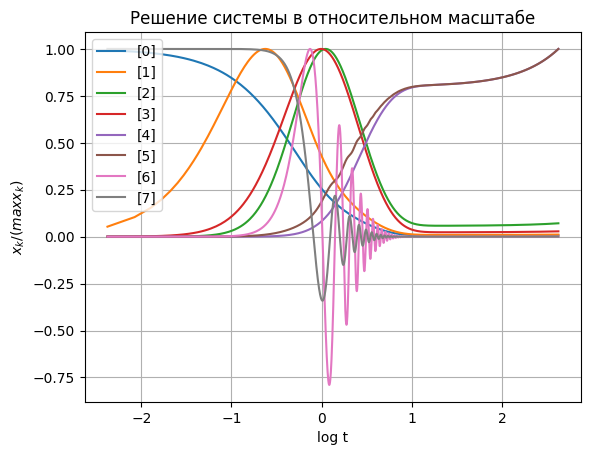

In [198]:
plt.title(f"Решение системы в относительном масштабе")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(task2_b6y[0][0])):
    plt.plot(numpy.log10(task2_b6t[0]), (task2_b6y[0][:, st])/max(task2_b6y[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

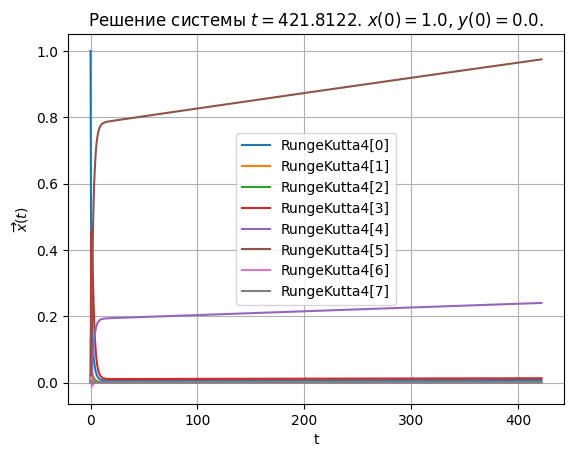

In [214]:
methods = [RungeKutta4]
task2_erk4t, task2_erk4y = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e5), methods, Task2)

/tmp/ipykernel_20500/2828745037.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(task2_erk4t[0]), (task2_erk4y[0][:, st])/max(task2_erk4y[0][:, st]), label = f"[{st}]")


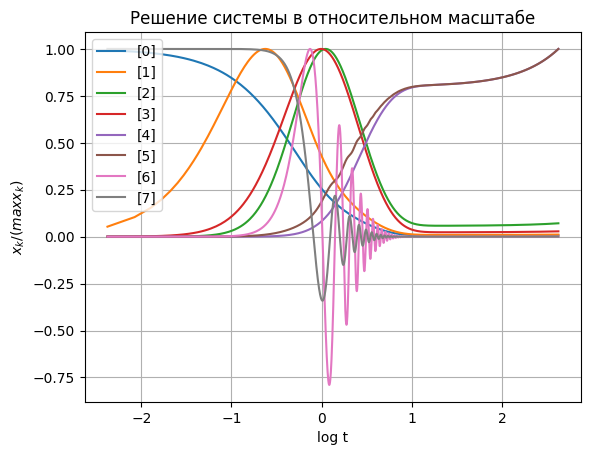

In [217]:
plt.title(f"Решение системы в относительном масштабе")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(task2_erk4y[0][0])):
    plt.plot(numpy.log10(task2_erk4t[0]), (task2_erk4y[0][:, st])/max(task2_erk4y[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

Решение неявным методом сходится при $10^3$ шагах, в отличие от явного метода.

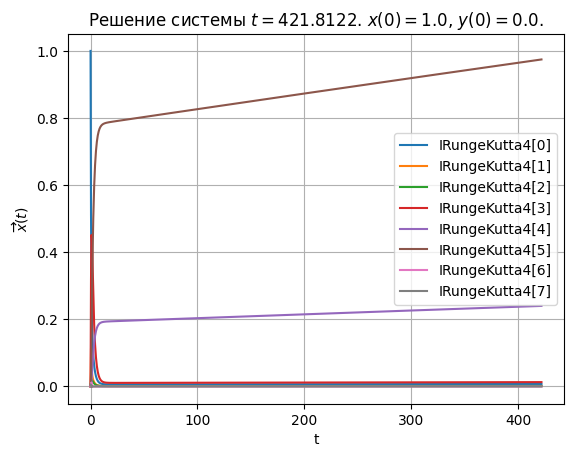

In [191]:
methods = [IRungeKutta4]
task2_ir4t, task2_ir4y = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e3), methods, Task2)

/tmp/ipykernel_20500/978286872.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(task2_ir4t[0]), (task2_ir4y[0][:, st])/max(task2_ir4y[0][:, st]), label = f"[{st}]")


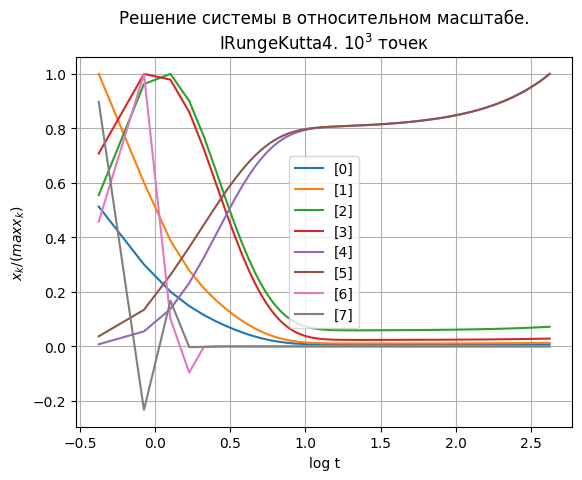

In [209]:
plt.title(f"Решение системы в относительном масштабе.\nIRungeKutta4. $10^3$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(task2_ir4y[0][0])):
    plt.plot(numpy.log10(task2_ir4t[0]), (task2_ir4y[0][:, st])/max(task2_ir4y[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

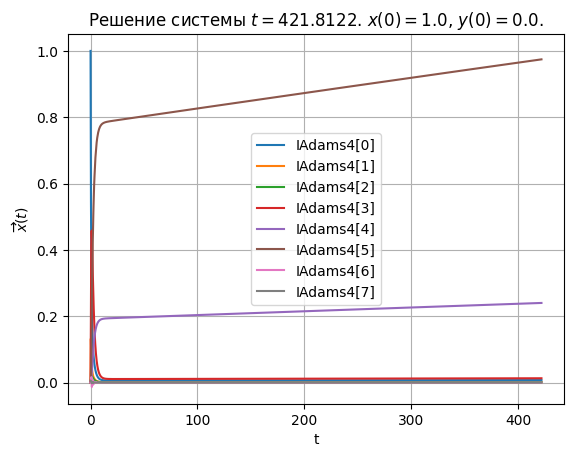

In [207]:
task2_a4t, task2_a4y = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e4), [IAdams4], Task2)

/tmp/ipykernel_20500/3639696379.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(task2_a4t[0]), (task2_a4y[0][:, st])/max(task2_a4y[0][:, st]), label = f"[{st}]")


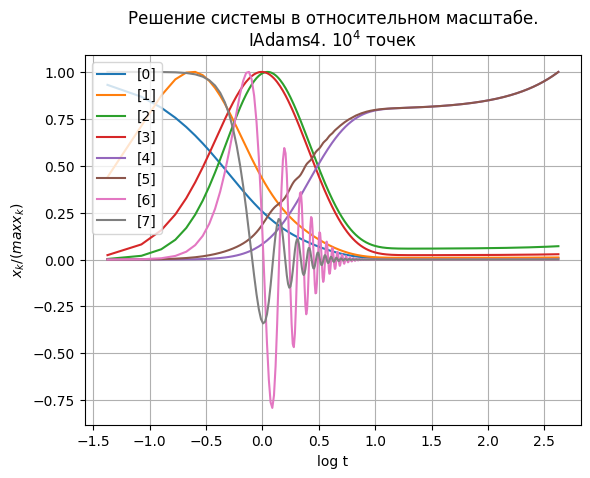

In [211]:
plt.title(f"Решение системы в относительном масштабе.\nIAdams4. $10^4$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(task2_a4y[0][0])):
    plt.plot(numpy.log10(task2_a4t[0]), (task2_a4y[0][:, st])/max(task2_a4y[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

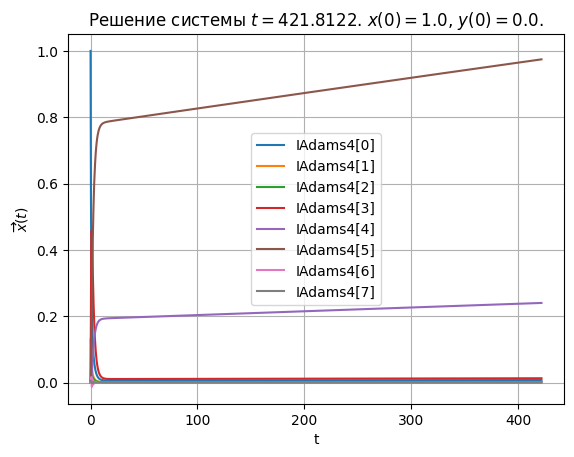

In [215]:
task2_a4t2, task2_a4y2 = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e5), [IAdams4], Task2)

/tmp/ipykernel_20500/3065863554.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(task2_a4t2[0]), (task2_a4y2[0][:, st])/max(task2_a4y2[0][:, st]), label = f"[{st}]")


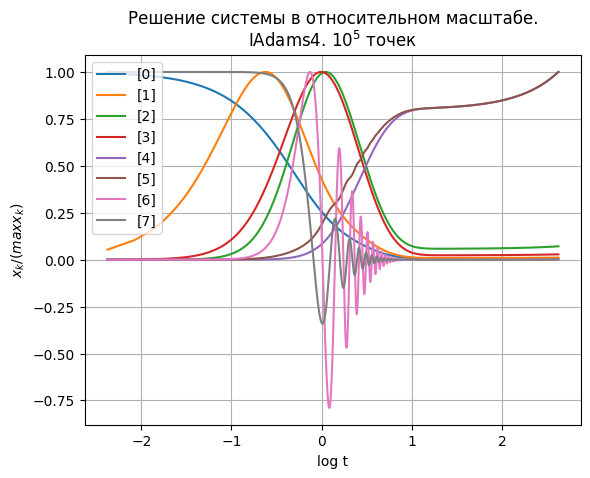

In [218]:
plt.title(f"Решение системы в относительном масштабе.\nIAdams4. $10^5$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(task2_a4y2[0][0])):
    plt.plot(numpy.log10(task2_a4t2[0]), (task2_a4y2[0][:, st])/max(task2_a4y2[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

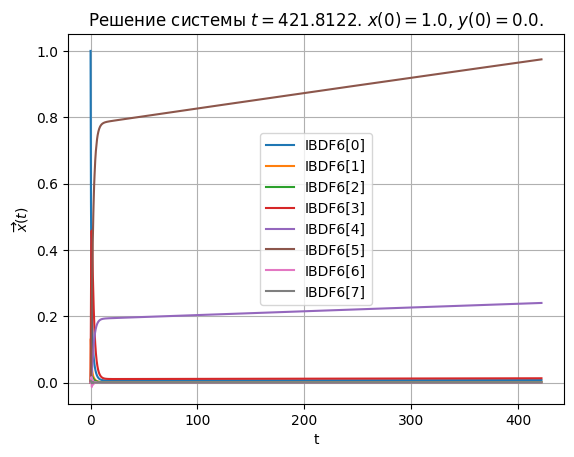

In [212]:
task2_bdf6t, task2_bdf6y = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e4), [IBDF6], Task2)

/tmp/ipykernel_20500/1191605913.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(task2_bdf6t[0]), (task2_bdf6y[0][:, st])/max(task2_bdf6y[0][:, st]), label = f"[{st}]")


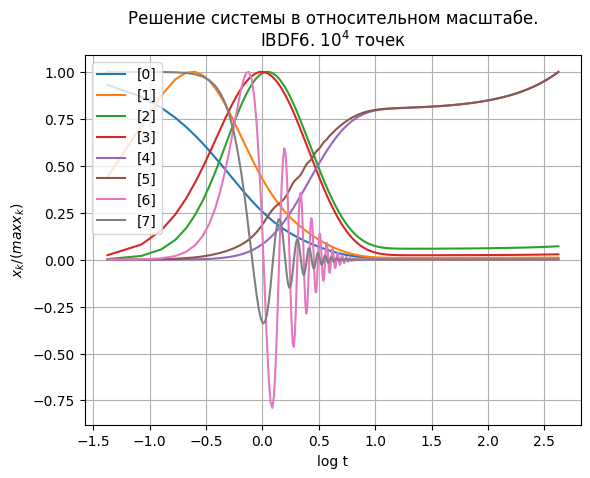

In [219]:
plt.title(f"Решение системы в относительном масштабе.\nIBDF6. $10^4$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(task2_bdf6y[0][0])):
    plt.plot(numpy.log10(task2_bdf6t[0]), (task2_bdf6y[0][:, st])/max(task2_bdf6y[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

Сравниваем явный метод Рунге-Кутты 4 порядка и неявный метод Адамса 4 порядка при $10^5$ точек.

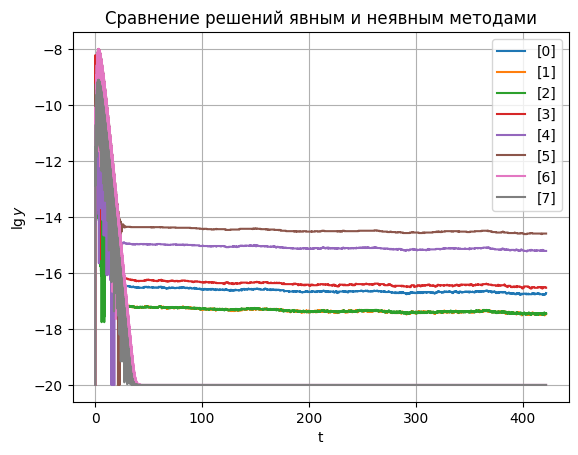

Отличие решений по норме 1: 10^(-7.997285979606021)


In [230]:
plt.title("Сравнение решений явным и неявным методами")
plt.xlabel("t")
plt.ylabel("$\lg y$")

delta = numpy.log10(numpy.abs(task2_erk4y[0] - task2_a4y2[0]) + 1e-20)

BuildPlot(task2_erk4t[0], delta, "")

plt.grid()
plt.legend()
plt.show()

print(f"Отличие решений по норме 1: 10^({math.log10(Norms.NormV1(task2_erk4y[0] - task2_a4y2[0]))})")

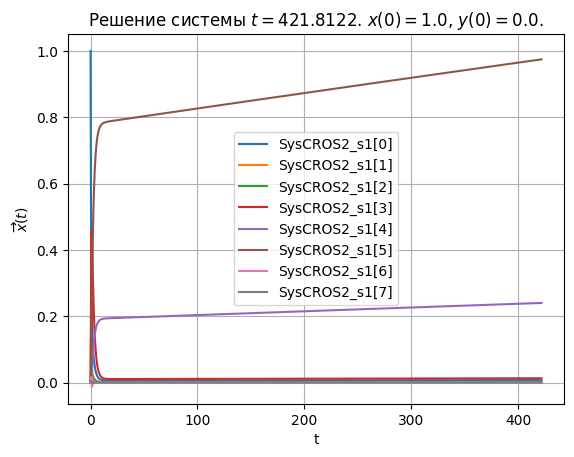

/tmp/ipykernel_20500/3234386628.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(tmpt[0]), (tmpy[0][:, st])/max(tmpy[0][:, st]), label = f"[{st}]")


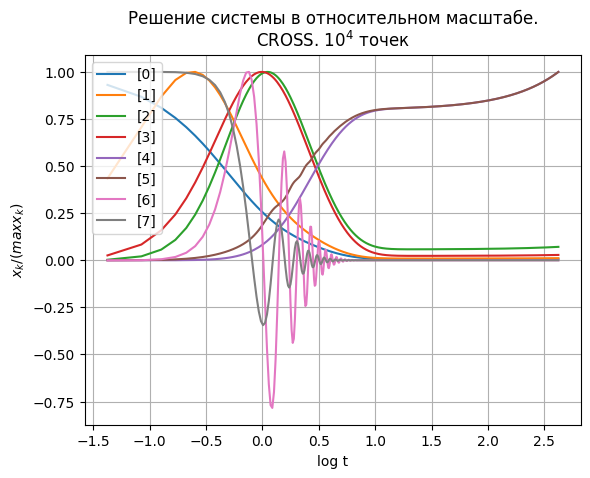

In [233]:
tmpt, tmpy = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e4), [SysCROS2_s1], Task2)

plt.title(f"Решение системы в относительном масштабе.\nCROSS. $10^4$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(tmpy[0][0])):
    plt.plot(numpy.log10(tmpt[0]), (tmpy[0][:, st])/max(tmpy[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

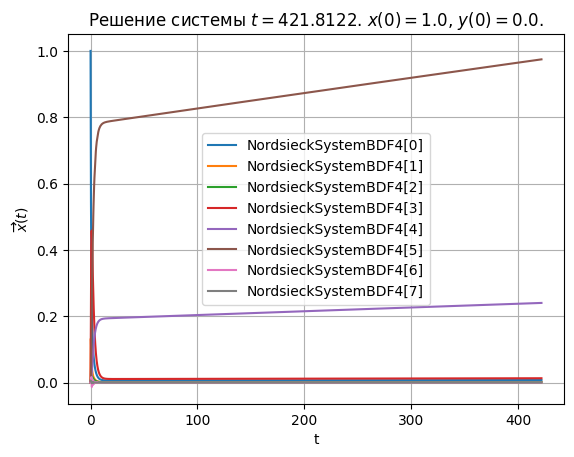

/tmp/ipykernel_5343/2443832362.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(tmpt[0]), (tmpy[0][:, st])/max(tmpy[0][:, st]), label = f"[{st}]")


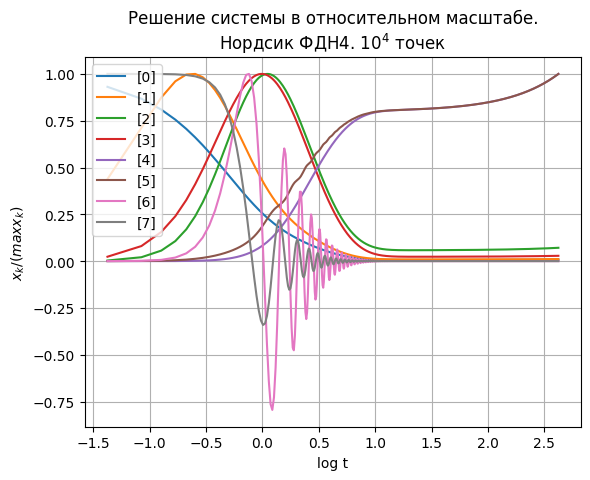

In [253]:
tmpt, tmpy = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e4), [NordsieckSystemBDF4], Task2)

plt.title(f"Решение системы в относительном масштабе.\nНордсик ФДН4. $10^4$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(tmpy[0][0])):
    plt.plot(numpy.log10(tmpt[0]), (tmpy[0][:, st])/max(tmpy[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()

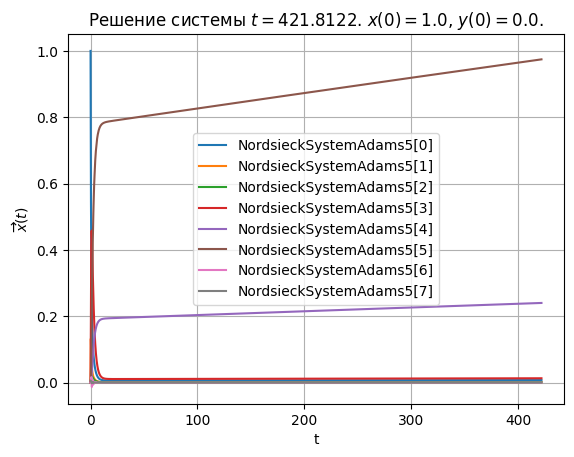

/tmp/ipykernel_5343/118961409.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.log10(tmpt[0]), (tmpy[0][:, st])/max(tmpy[0][:, st]), label = f"[{st}]")


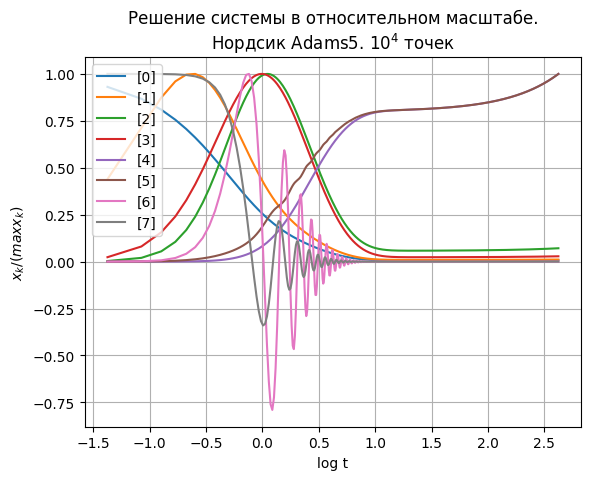

In [254]:
tmpt, tmpy = RunTask(Task2T1, Task2T2, Task2ZeroCond, int(1e4), [NordsieckSystemAdams5], Task2)

plt.title(f"Решение системы в относительном масштабе.\nНордсик Adams5. $10^4$ точек")
plt.xlabel("log t")
plt.ylabel(r"$x_k/(max x_k)$")
for st in range(0, len(tmpy[0][0])):
    plt.plot(numpy.log10(tmpt[0]), (tmpy[0][:, st])/max(tmpy[0][:, st]), label = f"[{st}]")
plt.grid()
plt.legend()
plt.show()